# CSE2530 Computational Intelligence
## Assignment 2: Ant Colony Optimization and Genetic Algorithms

#### Imports

In [1]:
"""
You may only use numpy to implement your algorithms
You can make use of any other libraries for miscellaneous functions, e.g. to create the visual aids.
Put all of your imports in this code block.
"""
import numpy as np
import random
import sys
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm # For progress bars
"""
The following classes are fully implemented in their own files and you should not change them.
Nonetheless, we encourage you to check how they work; this will help you get started.
"""
from Coordinate import Coordinate
from Direction import Direction
from PathSpecification import PathSpecification
from Route import Route
from SurroundingPheromone import SurroundingPheromone
from TSPData import TSPData
from Visualizer import Visualizer

## Randomly choose one of the parents, flip a coin# Part 1: The Travelling Robot Problem
### 1.1 Problem Analysis
#### Question 1:

<div style="background-color:#f1be3e">

"The problem can simply be stated as: if a traveling salesman wishes to visit exactly once each of a list of m cities (where the cost of traveling from city i to city j is cij ) and then return to the home city, what is the least costly route the traveling salesman can take?"

Hoffman, Karla L., Manfred Padberg, and Giovanni Rinaldi. "Traveling salesman problem." Encyclopedia of operations research and management science 1 (2013): 1573-1578.


#### Question 2

<div style="background-color:#f1be3e">

1. We don't need to go back to where we start. In classic TSP, after traveling through all the products, we also include the cost of traveling back to our starting position, which we do not do in this problem.
2. The nodes are not directly connected to all other nodes as in a complete graph. As we have a maze, a product might be in the way en route to another product, meaning the products are not guaranteed to be directly connected to all other products. 
3. The relative distances and paths for each product pair is not known. Since this is a maze, there may be multiple paths that lead from one product to another, and it might take computational power to get the shortest path between two products.

#### Question 3

<div style="background-color:#f1be3e">

Computational Intelligence techniques are appropriate to solve the TSP because they rely on heuristic approaches to find a near-optimum solution. This is great for the TSP because the TSP is an NP-hard problem that becomes increasingly difficult as the size of the problem grows. 

CI techniques skip the need for brute force and allow us to estimate the optimal solution, saving up on computation power required to tackle a problem such as the TSP. 

These techniques also usually converge, and usually get closer to the optimal solution the more iterations they undergo. This allows us to find better and better solutions across several iterations (or generations, in the context of genetic algorithms). Because of this, we can let them compute as long as we have time and use the best answer they found.

### 1.2 Genetic Algorithm

In [2]:
# TSP problem solver using genetic algorithms.
class GeneticAlgorithm:

    """
    Constructs a new 'genetic algorithm' object.
    @param generations: the amount of generations.
    @param pop_size: the population size.
    """
    def __init__(self, generations, pop_size, elite_size, p_crossover, p_mutation):
        self.generations = generations
        self.pop_size = pop_size
        self.elite_size = elite_size
        self.p_crossover = p_crossover
        self.p_mutation = p_mutation
    """
    This method should solve the TSP.
    @param tsp_data: the data describing the problem.
    @return the optimized product sequence.
    """
    def solve_tsp(self, tsp_data):
        product_locations = tsp_data.product_locations
        distance_matrix = tsp_data.get_distances()
        start_distances = tsp_data.get_start_distances()
        end_distances = tsp_data.get_end_distances()
        product_list = [i for i in range(len(product_locations))]
        current_generation = initial_population(self.pop_size, product_list)
        print("Initial distance: " + str(1 / rank_routes(current_generation, distance_matrix, start_distances, end_distances)[0][1]))
    
        for i in range(0, self.generations):
            current_generation = next_generation(current_generation, self.elite_size, self.p_crossover, self.p_mutation,distance_matrix, start_distances, end_distances)
    
        print("Final distance: " + str(1 / rank_routes(current_generation,distance_matrix, start_distances, end_distances)[0][1]))
        best_route_index = rank_routes(current_generation,distance_matrix, start_distances, end_distances)[0][0]
        best_route = current_generation[best_route_index]
        return best_route
    
    def solve_tsp_visual(self, tsp_data):
        product_locations = tsp_data.product_locations
        distance_matrix = tsp_data.get_distances()
        start_distances = tsp_data.get_start_distances()
        end_distances = tsp_data.get_end_distances()
        product_list = [i for i in range(len(product_locations))]
        current_generation = initial_population(self.pop_size, product_list)
        print("Initial distance: " + str(1 / rank_routes(current_generation, distance_matrix, start_distances, end_distances)[0][1]))
    
        best_route_distances = []
        for i in range(0, self.generations):
            if i % 20 == 0: 
                best_route_distances.append(1 / rank_routes(current_generation, distance_matrix, start_distances, end_distances)[0][1])
            current_generation = next_generation(current_generation, self.elite_size, self.p_crossover, self.p_mutation,distance_matrix, start_distances, end_distances)

        print("Final distance: " + str(1 / rank_routes(current_generation,distance_matrix, start_distances, end_distances)[0][1]))
        best_route_index = rank_routes(current_generation,distance_matrix, start_distances, end_distances)[0][0]
        best_route = current_generation[best_route_index]
        best_route_distances.append(1 / rank_routes(current_generation, distance_matrix, start_distances, end_distances)[0][1])
        return best_route, best_route_distances
    

In [3]:
class Fitness:
    def __init__(self, route, distance_matrix, start_distances, end_distances):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
        self.distance_matrix = distance_matrix
        self.start_distances = start_distances
        self.end_distances = end_distances

    def route_distance(self):
        if self.distance ==0:
            path_distance = self.start_distances[self.route[0]]
            for i in range(0, len(self.route) - 1):
                from_product_number = self.route[i]
                to_product_number = self.route[i + 1]
                path_distance += self.distance_matrix[from_product_number][to_product_number]
            path_distance += self.end_distances[self.route[len(self.route) - 1]] + len(self.route)
            self.distance = path_distance
        return self.distance
    
    def route_fitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.route_distance())
        return self.fitness

In [4]:
def create_route(product_list):
    route = random.sample(product_list, len(product_list)) # Randomly shuffle the products, this preserves the original list
    return route

In [5]:
def initial_population(population_size, product_list):
    population = []
    for i in range(0, population_size):
        population.append(create_route(product_list))
    return population

In [6]:
def rank_routes(population,distance_matrix, start_distances, end_distances):
    fitness_results = {}
    for i in range(0,len(population)):
        fitness_results[i] = Fitness(population[i],distance_matrix, start_distances, end_distances).route_fitness()
    # Sort the fitness results in descending order and return a sorted list of tuples, where each tuple contains: (an index, the corresponding route fitness)
    return sorted(fitness_results.items(), key=lambda x: x[1], reverse=True) # E.g. [(2, 0.9), (0, 0.8), (1, 0.7)]

In [7]:
def roulette_wheel_selection(population_ranked, elite_size):
    selection_results = []
    population_ranked_array = np.array(population_ranked)
    population_ranked_fitness = population_ranked_array[:,1]
    population_ranked_ids = population_ranked_array[:,0].astype(int)
    total_fitness = np.sum(population_ranked_fitness)
    
    # Calculate cumulative probabilities
    cumulative = np.cumsum(population_ranked_fitness) / total_fitness * 100
    
    # Select elites
    selection_results.extend(population_ranked_ids[:elite_size]) # Add the ids of the elite routes
    
    # Select the rest using roulette wheel
    for _ in range(len(population_ranked) - elite_size):
        pick = 100 * np.random.random()
        selected_index = np.argmax(cumulative >= pick)
        selection_results.append(population_ranked_ids[selected_index])

    return selection_results # return the ids of the selected routes

In [8]:
def mating_pool(population, selection_results):
    mating_pool = []
    for i in range(0, len(selection_results)):
        index = selection_results[i]
        mating_pool.append(population[index])
    return mating_pool # return the selected routes, the first few routes are the elites

In [9]:
def breed(parent_1, parent_2):
    start_gene = int(random.random() * len(parent_1))
    child_parent_1 = parent_1[start_gene:] # the part of parent 1 that will be added to the child
    # only add the genes that are not in the child from parent 1
    child_parent_2 = [gene for gene in parent_2 if gene not in child_parent_1]
    child = child_parent_2 + child_parent_1 # concatenate the two parts
    return child

In [10]:
def breed_population(mating_pool, elite_size, p_crossover):
    children = []
    pool = random.sample(mating_pool, len(mating_pool))

    for i in range(0,elite_size):
        children.append(mating_pool[i])
    
    for i in range(0, len(mating_pool) - elite_size):
        parent_1 = pool[i]
        parent_2 = pool[len(mating_pool)-i-1]
        if random.random() < p_crossover:
            child = breed(parent_1, parent_2)
            children.append(child)
        else:
            # Randomly choose one of the parents, flip a coin
            if random.random() > 0.5: 
                children.append(parent_1)
            else:
                children.append(parent_2)
    return children

In [11]:
def mutate(route, p_mutation):
    for swapped in range(len(route)):
        if random.random() < p_mutation:
            swapWith = int(random.random() * len(route))
            
            product_1 = route[swapped]
            product_2 = route[swapWith]
            
            route[swapped] = product_2
            route[swapWith] = product_1
    return route

In [12]:
def mutate_population(population, p_mutation):
    mutated_population = []
    
    for route in population:
        mutated_route = mutate(route, p_mutation)
        mutated_population.append(mutated_route)
    return mutated_population

In [13]:
def next_generation(current_generation, elite_size, p_crossover, p_mutation,distance_matrix, start_distances, end_distances):
    population_ranked = rank_routes(current_generation,distance_matrix, start_distances, end_distances)
    selection_results = roulette_wheel_selection(population_ranked, elite_size)
    matingpool = mating_pool(current_generation, selection_results)
    children = breed_population(matingpool, elite_size, p_crossover)
    next_generation = mutate_population(children, p_mutation)
    return next_generation

#### Question 4

<div style="background-color:#f1be3e">

The genes represent the product numbers. We will encode the chromosomes as a list of product numbers representing the order in which our robot should take each product. 


#### Question 5

<div style="background-color:#f1be3e">

The fitness function is the reciprocal of the total distance traveled by the robot traversing a chromosome (which, in this case, is the list of product numbers). This gives longer paths a lower score than shorter paths, which allows us to choose longer paths less often in the breeding process later in comparison to shorter paths. This helps us in finding a solution that hopefully inherits more of the shorter paths.

#### Question 6

<div style="background-color:#f1be3e">

First, we create a roulette wheel. The routes with better fitness scores will take bigger proportion on the wheel. Then we randomly sample from the population based on the probabilities in the roulette wheel for the current mating pool. Later on we select the parents from the mating pool in pairs. 

#### Question 7

<div style="background-color:#f1be3e">

We implemented "Crossover" and "Mutation" in our genetic algorithm.

Crossover allows us to combine the current best solutions in hopes of getting a better solution while still allowing for exploration where combining worse solutions might create a better one.

Mutation allows us to break free from local minima through small, random changes in our chromosome. As crossover tends to combine the best solutions, we might get stuck at a certain sequence. 

#### Question 8

<div style="background-color:#f1be3e">

We prevent local minima through the mutation function. As the crossover function tends to breed the most optimal functions together, our population might become more homogenous over time and get stuck on a smaller set of sequences.

Our crossover function also allows for the selection of worse solutions to breed, although this happens less often than better solutions. This allows us to explore sequences that are vastly different from the best solutions, allowing for further exploration into other sequences.

#### Question 9

<div style="background-color:#f1be3e">

Elitism is the preservation of the best solution of each generation to the next one's mating pool. We have applied this in our implementation, because it converges faster since we are always exploring based on our solution containing our current best elites.

#### Question 10

Initial distance: 4567.0
Final distance: 1897.0


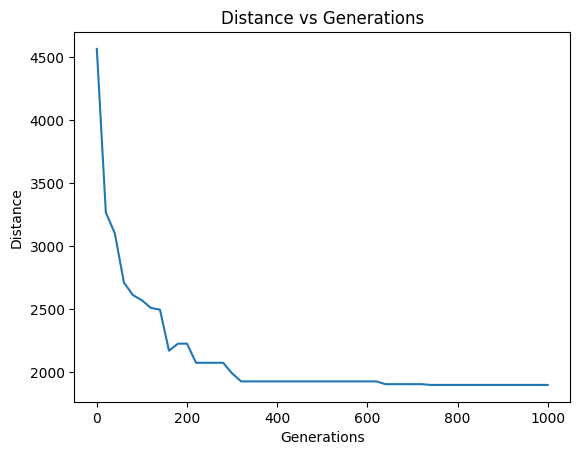

Solution: [0, 1, 7, 17, 8, 13, 4, 6, 15, 3, 9, 14, 11, 12, 5, 10, 2, 16]
All elements are unique


In [83]:
# Please keep your parameters for the Genetic Algorithm easily changeable here
population_size = 20
generations = 1000
p_crossover = 0.7
p_mutation = 0.01
elite_size = 3
persist_file = "./../data/optimal_tsp"

# Setup optimization
tsp_data = TSPData.read_from_file(persist_file)
ga = GeneticAlgorithm(generations, population_size, elite_size, p_crossover, p_mutation)

# Run optimzation and write to file
ga_solution, distances = ga.solve_tsp_visual(tsp_data)

plt.plot(range(0, 1001, 20), distances)
plt.xlabel("Generations")
plt.ylabel("Distance")
plt.title("Distance vs Generations")
plt.show()

print("Solution:", ga_solution)

# does solution have unique values
if(len(set(ga_solution)) == len(ga_solution)):
    print("All elements are unique")
tsp_data.write_action_file(ga_solution, "./../data/tsp_solution.txt")

In [64]:
print("Order:", [x + 1 for x in ga_solution])

Order: [1, 2, 7, 5, 14, 16, 4, 9, 8, 18, 10, 15, 12, 13, 6, 11, 3, 17]


<div style="background-color:#f1be3e">

The length of our solution is 1517. This solution seems to be a local optimal, but we have no way of guaranteeing whether this is the best solution available. 

## Part 2: Path Finding Through Ant Colony Optimization
### 2.2 Observing the Problem

#### Question 11

<div style="background-color:#f1be3e">
The purpose of Ant Colony Optimization (also known as ACO) is to try to find the shortest path to some goal from a starting position. For example, in the travelling salesman problem, ACO tries to find the shortest path that visits each city exactly once.

The idea of ACO is to simulate the real world process of how ants indirectly communicate with each other to forage. This is done using pheromone trails. Ants walk through steps randomly, but steps with greater pheromone amounts get chosen more frequently. More pheromone is given to each step in a path the shorter the path is. After a few iterations, ants will more often walk through paths with the largest amounts of pheromones, which would most likely be the shortest path found by the ants.

ACO is good in settings where the environment keeps changing and the conditions are unknown. For example, it could be good to find the shortest route to a destination in a navigation app, as heavy traffic, accidents, and road work could change the cost of traversing a road depending on time, and the ants adapt to these changes pretty quickly.

#### Question 12

<div style="background-color:#f1be3e">

1. Dead-ends. The maze could have a many routes that result in dead-ends. This makes it difficult as we would then need to remove the pheromone in the path such that future ants will not also traverse the dead-end path.

2. Many routes to the same destination from a single starting point with similar distances. If the maze has different routes to the finish, we need the ACO to be able to try the different routes, too, without getting stuck on one solution that may be suboptimal.

#### Question 13

$$
\Delta\tau_{ij}^k=\frac{Q}{L_{k}}\\
\Delta\tau_{ij}^k= \text{The amount of pheromone on path ij by ant k}\\
Q = \text{Constant} \\
L_{k} = \text{Link Length}
$$

The ants need to drop pheromone as a way to "communicate" to other ants the path they have found to the finish. They drop pheromones as an indication to future ants in the next generation the path they took. These future ants are then more likely to travel in paths with more pheromones on them.

#### Question 14

$$
\tau_{ij}=(1-\rho)\cdot\tau_{ij}+\sum_{k=1}^{m} \Delta\tau_{ij}^k\\
\tau_{ij} = \text{The amount of pheromone on path ij}\\
\rho = \text{Evaporation Constant} \\
\sum_{k=1}^{m}\Delta\tau_{ij}^k = \text{The sum of all the pheronome released during the round by all ants}
$$

Pheromone needs to evaporate so that ants do not get stuck traversing suboptimal paths (local minima). With evaporation, the ants are able to consider different routes to the end destination. In our implementation, this is set to 0.1, so that 90% of the pheromones carry over to the next generation.

### 2.3 Implementing the Ant Algorithm

In [15]:
# Class that represents the basic Ant functionality
class StandardAnt:

    """
    Constructor of a StandardAnt taking a Maze and PathSpecification
    @param maze: the Maze where the ant will try to find a route
    @param path_specification: the PathSpecification consisting of a start and an end coordinate
    """
    def __init__(self, maze, path_specification, alpha=1, evaporation_factor=0.1):
        self.maze = maze
        self.start = path_specification.get_start()
        self.end = path_specification.get_end()
        self.current_position = self.start
        self.rand = random
        self.alpha = alpha
        self.evaporation_factor = evaporation_factor
        

    """
    Method that performs a single complete run through the maze by the ant
    @return the route found by the ant
    """
    def find_route(self):
        route = Route(self.start)
        while self.current_position!=self.end:
            neighbouring_pheromones = self.maze.get_surrounding_pheromone(self.current_position)
            directions = [Direction.north, Direction.east, Direction.south, Direction.west]
            # pheromones in the NESW directions, if the direction is not possible, the pheromone is 0
            # e.g. not in bounds
            pheromones_NESW = [] 
            for direction in directions:
                neighbour = self.current_position.add_direction(direction)
                if self.maze.in_bounds(neighbour):
                    pheromones_NESW.append(neighbouring_pheromones.get(direction))
                else:
                    pheromones_NESW.append(0)
            # calculate the probability of each direction
            pheromones_NESW = np.array(pheromones_NESW)
            total_pheromones = np.sum(pheromones_NESW ** self.alpha)
            probabilities = pheromones_NESW ** self.alpha / total_pheromones
            # choose a direction based on the probabilities
            next_direction = self.rand.choices(directions, weights=probabilities, k=1)[0]
            route.add(next_direction)
            self.current_position = self.current_position.add_direction(next_direction)
        return route

            
        
        


In [16]:
# Class that holds all of the maze data.
# This includes the pheromones, the open and blocked tiles in the system,
# and the starting and end coordinates for the ants.
class Maze:

    """
    Constructor of a Maze
    @param walls: array of ints representing the accessible (1) and inaccessible (0) tiles
    @param width: the width (horizontal dimension) of the Maze
    @param length: the length (vertical dimension) of the Maze
    """
    def __init__(self, walls, width, length):
        self.walls = walls
        self.length = length
        self.width = width
        self.start = None
        self.end = None
        self.pheromones = None
        self.initialize_pheromones()
        
    """
    Initialize pheromones on all tiles of the Maze
    """
    def initialize_pheromones(self):
        self.pheromones = copy.deepcopy(self.walls)

    """
    Reset the Maze for a new shortest path problem
    """
    def reset(self):
        self.initialize_pheromones()

    """
    Update the pheromones along a certain route according to a certain Q
    @param route: the route taken by an ant
    @param q: the normalization factor for the amount of dropped pheromone
    """
    def add_pheromone_route(self, route, q):
        position = route.get_start()
        route_length = route.size()
        route_dirs = route.get_route()
        for i in range(route_length):
            position = position.add_direction(route_dirs[i])
            self.pheromones[position.get_x()][position.get_y()] += q / route_length


    """
    Update pheromones for a list of routes
    @param routes: a list of routes taken by the ants
    @param q: the normalization factor for the amount of dropped pheromone
    """
    def add_pheromone_routes(self, routes, q):
        for r in routes:
            self.add_pheromone_route(r, q)

    """
    Evaporate pheromone
    @param rho: the evaporation factor
    """
    def evaporate(self, rho):
        self.pheromones = np.multiply(self.pheromones, (1 - rho))

    """
    Getter for the width of the maze
    @return the width of the maze
    """
    def get_width(self):
        return self.width

    """
    Getter for the length of the maze
    @return the length of the maze
    """
    def get_length(self):
        return self.length

    """
    Returns a the amount of pheromones on the neighbouring positions (N/S/E/W)
    @param position: the coordinate where we need to check the surrounding pheromones
    @return the pheromones on the neighbouring coordinates.
    """
    def get_surrounding_pheromone(self, position):
        north_coord = position.add_direction(Direction.north)
        east_coord = position.add_direction(Direction.east)
        south_coord = position.add_direction(Direction.south)
        west_coord = position.add_direction(Direction.west)
        return SurroundingPheromone(self.get_pheromone(north_coord), self.get_pheromone(east_coord), self.get_pheromone(south_coord), self.get_pheromone(west_coord))




    """
    Getter for the pheromones on a specific coordinate.
    If the position is not in bounds returns 0
    @param pos: coordinate for the poition of interest
    @return the amount of pheromone at the specified poition
    """
    def get_pheromone(self, pos):
        if self.in_bounds(pos):
            return self.pheromones[pos.get_x()][pos.get_y()]
        return 0

    """
    Check whether a coordinate lies in the bounds of the current maze
    @param position: the position that we need to check
    @return true if the coordinate lies within the current maze
    """
    def in_bounds(self, position):
        return position.x_between(0, self.width) and position.y_between(0, self.length)

    """
    Representation of Maze as defined by the input file format.
    @return the human-readable representation of a maze
    """
    def __str__(self):
        string = ""
        string += str(self.width)
        string += " "
        string += str(self.length)
        string += " \n"
        for y in range(self.length):
            for x in range(self.width):
                string += str(self.walls[x][y])
                string += " "
            string += "\n"
        return string

    """
    Method that builds a maze from a file
    @param file_path: path to the file which stores the maze
    @return a maze object with pheromones initialized to 0s on inaccessible and 1s on accessible tiles
    """
    @staticmethod
    def create_maze(file_path):
        try:
            f = open(file_path, "r")
            lines = f.read().splitlines()
            dimensions = lines[0].split(" ")
            width = int(dimensions[0])
            length = int(dimensions[1])
            
            #make the maze_layout
            maze_layout = []
            for x in range(width):
                maze_layout.append([])
            
            for y in range(length):
                line = lines[y+1].split(" ")
                for x in range(width):
                    if line[x] != "":
                        state = int(line[x])
                        maze_layout[x].append(state)
            print("Ready reading maze file " + file_path)
            return Maze(maze_layout, width, length)
        except FileNotFoundError:
            print("Error reading maze file " + file_path)

In [17]:
# Class representing the complete ACO algorithm.
# Finds shortest path between two points in a maze according to a path specification.
class AntColonyOptimization:

    """
    Constructs a new optimization object using the ant algorithm
    @param maze: the maze (environment) for ants
    @param ants_per_gen: the number of ants per generation (between update of pheromones)
    @param generations: the total number of generations of ants (pheromone updates)
    @param q: the normalization factor for the amount of dropped pheromone
    @param evaporation: the evaporation factor for the pheromones
    """
    def __init__(self, maze, ants_per_gen, generations, q, evaporation):
        self.maze = maze
        self.ants_per_gen = ants_per_gen
        self.generations = generations
        self.q = q
        self.evaporation = evaporation

    """
    Loop that starts the shortest path process
    @param path_specification: description of the route we wish to optimize
    @return the optimized route according to the ACO algorithm
    """
    def find_shortest_route(self, path_specification):
        self.maze.reset()
        shortest_route = None
        for i in range(self.generations):
            routes = []
            for j in range(self.ants_per_gen):
                ant = StandardAnt(self.maze, path_specification, evaporation_factor=self.evaporation)
                route = ant.find_route()
                routes.append(route)
                if shortest_route is None or route.shorter_than(shortest_route):
                    shortest_route = route
            self.maze.evaporate(self.evaporation)
            self.maze.add_pheromone_routes(routes, self.q)
        return shortest_route

In [18]:
def pheromones_visualizer(maze):
    pheromones = np.transpose(np.array(maze.pheromones))
    plt.figure(figsize=(15,15))
    plt.imshow(pheromones, cmap='Oranges', interpolation='nearest')
    plt.colorbar()
    plt.title("Pheromones")
    plt.show()

Ready reading maze file ./../data/toy_maze.txt
Time taken: 432.078
Route size: 624


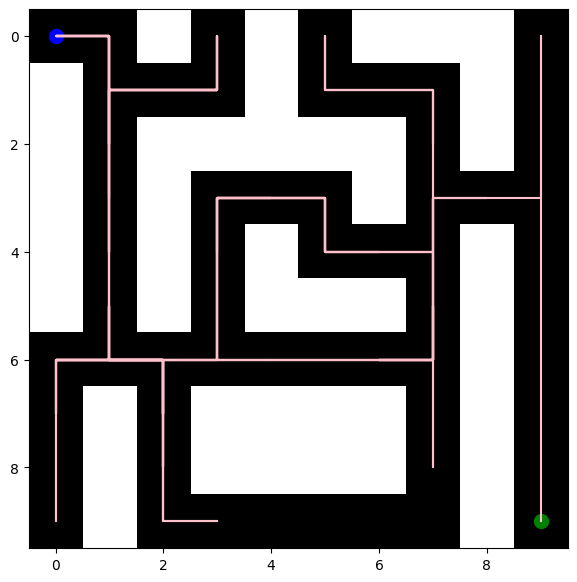

In [19]:
# Please keep your parameters for the ACO easily changeable here
gen = 5
no_gen = 5
q = 1600
evap = 0.1

# Construct the optimization objects
maze = Maze.create_maze("./../data/toy_maze.txt")
spec = PathSpecification.read_coordinates("./../data/toy_coordinates.txt")
aco = AntColonyOptimization(maze, gen, no_gen, q, evap)

start_time = int(round(time.time() * 1000))
shortest_route = aco.find_shortest_route(spec)

print("Time taken: " + str((int(round(time.time() * 1000)) - start_time) / 1000.0))
print("Route size: " + str(shortest_route.size()))

shortest_route.write_to_file("./../data/toy_solution.txt")
Visualizer.visualize_individual_path(maze, shortest_route, spec)

### 2.4 Upgrading Your Ants with Intelligence

#### Question 15

In [20]:
# Class that represents the intelligent Ant
class IntelligentAnt:

    """
    Constructor of an IntelligentAnt taking a Maze and PathSpecification
    @param maze: the Maze where the ant will try to find a route
    @param path_specification: the PathSpecification consisting of a start and an end coordinate
    """
    def __init__(self, maze, path_specification, alpha=1):
        self.maze = maze
        self.start = path_specification.get_start()
        self.end = path_specification.get_end()
        self.current_position = self.start
        self.rand = random
        self.visited = np.zeros((self.maze.get_width(), self.maze.get_length()))
        self.alpha = alpha
    """
    Method that performs a single complete run through the maze by the ant
    @return the route found by the ant
    """
    def find_route(self):
        turning_points = [] # store the turning points where the ant has more than one possible direction
        route = Route(self.start)
        while self.current_position!=self.end:
            self.visited[self.current_position.get_x()][self.current_position.get_y()] = 1
            neighbouring_pheromones = self.maze.get_surrounding_pheromone(self.current_position)
            directions = [Direction.north, Direction.east, Direction.south, Direction.west]
            # pheromones in the NESW directions, if the direction is not possible, the pheromone is 0
            # e.g. already visited or not in bounds, can avoid cycles
            pheromones_NESW = [] 
            neighbouring_pheromones_list = []
            for direction in directions:
                neighbour = self.current_position.add_direction(direction)
                neighbouring_pheromones_list.append(neighbouring_pheromones.get(direction))
                if self.maze.in_bounds(neighbour) and self.visited[neighbour.get_x()][neighbour.get_y()] == 0:# can delete bound check i think
                    pheromones_NESW.append(neighbouring_pheromones.get(direction))
                else:
                    pheromones_NESW.append(0)
            # calculate the probability of each direction
            pheromones_NESW = np.array(pheromones_NESW)
            # check if there are more than one possible directions
            if np.count_nonzero(pheromones_NESW) > 1:
                turning_points.append(self.current_position) # store the turning point
            total_pheromones = np.sum(pheromones_NESW ** self.alpha)
            if total_pheromones == 0:
                turning_point = turning_points.pop()
                if np.count_nonzero(np.array(neighbouring_pheromones_list)) == 1: # only one neighboring direction has pheromone, that is where we came from, so dead end
                    self.revert_to_turning_point(route, turning_point, True) # revert to the turning point and evaporate the path
                else:
                    self.revert_to_turning_point(route, turning_point, False) # no possible directions, since we have visited all the neighbors or the neighbors are walls or just no pheromones
                continue
            probabilities = pheromones_NESW ** self.alpha / total_pheromones
            # choose a direction based on the probabilities
            next_direction = self.rand.choices(directions, weights=probabilities, k=1)[0]
            route.add(next_direction)
            self.current_position = self.current_position.add_direction(next_direction)
        # if self.current_position!=self.end:
        #     self.maze.dead_end_route_evaporation(route, self.evaporation_factor)
        #     return None
        return route
    
    # revert the route and the current position to the turning point
    def revert_to_turning_point(self, route, turning_point,dead_end):
        while self.current_position != turning_point:
            last_direction = route.remove_last()
            # set the pheromone to 0
            if dead_end:
                self.maze.pheromones[self.current_position.get_x()][self.current_position.get_y()] = 0
            self.current_position = self.current_position.subtract_direction(last_direction)

    
            


In [21]:
# Class representing the complete ACO algorithm.
# Finds shortest path between two points in a maze according to a path specification.
class IntelligentAntColonyOptimization:

    """
    Constructs a new optimization object using the ant algorithm
    @param maze: the maze (environment) for ants
    @param ants_per_gen: the number of ants per generation (between update of pheromones)
    @param generations: the total number of generations of ants (pheromone updates)
    @param q: the normalization factor for the amount of dropped pheromone
    @param evaporation: the evaporation factor for the pheromones
    """
    def __init__(self, maze, ants_per_gen, generations, q, evaporation, alpha=1, early_stop_threshold=10):
        self.maze = maze
        self.ants_per_gen = ants_per_gen
        self.generations = generations
        self.q = q
        self.evaporation = evaporation
        self.alpha = alpha
        self.early_stop_threshold = early_stop_threshold

    """
    Loop that starts the shortest path process
    @param path_specification: description of the route we wish to optimize
    @return the optimized route according to the ACO algorithm
    """
    def find_shortest_route(self, path_specification):
        self.maze.reset()
        shortest_route = None
        counter = 0
        for i in range(self.generations):
            routes = []
            shortest_route_this_gen = None
        
            for j in range(self.ants_per_gen):
                ant = IntelligentAnt(self.maze, path_specification, alpha=self.alpha)
                route = ant.find_route()
                routes.append(route)
                if shortest_route is None or route.shorter_than(shortest_route):
                    counter = 0 # reset the counter if the shortest route has changed
                    shortest_route = route
                if shortest_route_this_gen is None or route.shorter_than(shortest_route_this_gen):
                    shortest_route_this_gen = route
                    
            self.maze.evaporate(self.evaporation)
            self.maze.add_pheromone_routes(routes, self.q)
            # if the shortest route has not changed for a few generations
            if counter < self.early_stop_threshold: 
                if shortest_route_this_gen == shortest_route:
                    counter += 1 # increment the counter if we have found the exact same shortest route in this generation and it is still the shortest route
                else:
                    counter = 0 # reset the counter if in this generation the shortest route is not the optimal route so far, because the possibility of going to other paths is increased
            else:
                break
        return shortest_route

Ready reading maze file ./../data/hard_maze.txt
Time taken: 92.825
Route size: 863


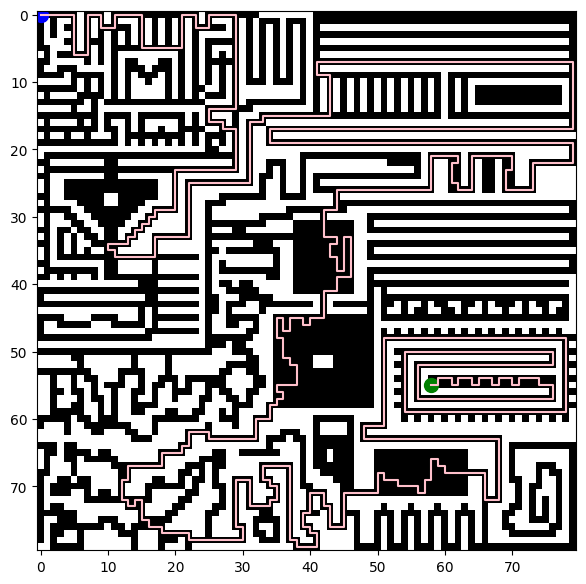

In [22]:
# Please keep your parameters for the ACO easily changeable here
gen = 50
no_gen = 50
q = 1600
evap = 0.1

# Construct the optimization objects
maze = Maze.create_maze("./../data/hard_maze.txt")
spec = PathSpecification.read_coordinates("./../data/hard_coordinates.txt")
aco = IntelligentAntColonyOptimization(maze, gen, no_gen, q, evap, alpha=1)

start_time = int(round(time.time() * 1000))
shortest_route = aco.find_shortest_route(spec)

print("Time taken: " + str((int(round(time.time() * 1000)) - start_time) / 1000.0))
print("Route size: " + str(shortest_route.size()))

shortest_route.write_to_file("./../data/hard_solution.txt")
Visualizer.visualize_individual_path(maze, shortest_route, spec)

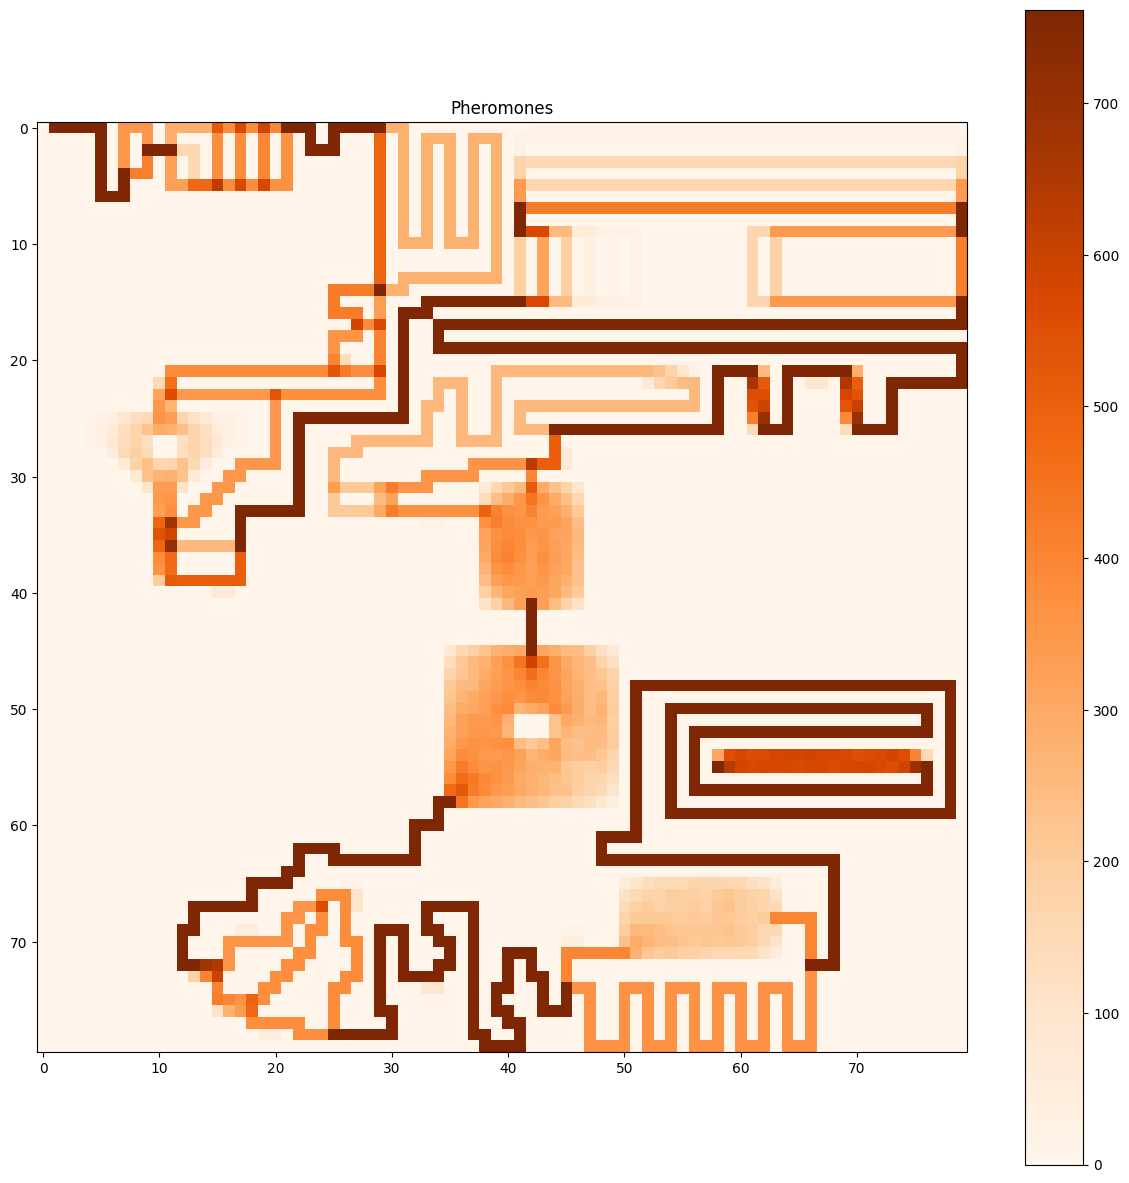

In [23]:
pheromones_visualizer(maze)

Ready reading maze file ./../data/toy_maze.txt
Time taken: 476.119
Route size: 1152


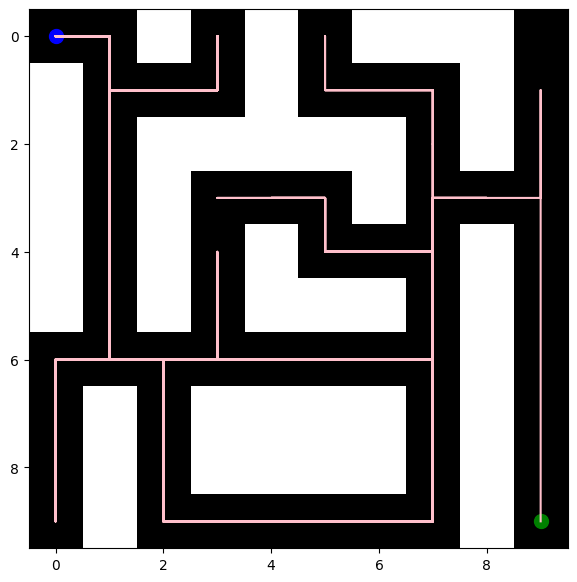

Time taken: 0.02
Route size: 24


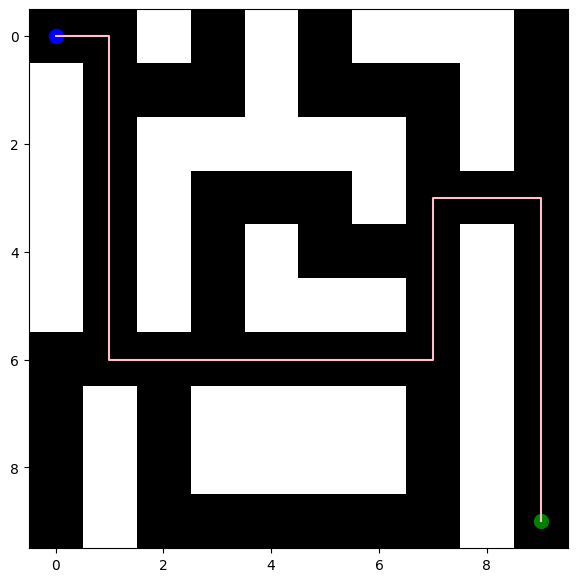

In [24]:
# Please keep your parameters for the ACO easily changeable here
gen = 5
no_gen = 5
q = 1600
evap = 0.1

# Construct the optimization objects
maze = Maze.create_maze("./../data/toy_maze.txt")
spec = PathSpecification.read_coordinates("./../data/toy_coordinates.txt")
aco = AntColonyOptimization(maze, gen, no_gen, q, evap)

start_time = int(round(time.time() * 1000))
shortest_route = aco.find_shortest_route(spec)

print("Time taken: " + str((int(round(time.time() * 1000)) - start_time) / 1000.0))
print("Route size: " + str(shortest_route.size()))

Visualizer.visualize_individual_path(maze, shortest_route, spec)
smart_aco = IntelligentAntColonyOptimization(maze, gen, no_gen, q, evap, alpha=1)

start_time = int(round(time.time() * 1000))
shortest_route = smart_aco.find_shortest_route(spec)

print("Time taken: " + str((int(round(time.time() * 1000)) - start_time) / 1000.0))
print("Route size: " + str(shortest_route.size()))
Visualizer.visualize_individual_path(maze, shortest_route, spec)

<div style="background-color:#f1be3e">

Optimizations:
1. Removing pheromone on dead-end paths and returning back to junctions. When an ant comes across a junction, if the path it ends up choosing results in a dead-end, the ant's position is moved back to the junction and the dead-end path is removed from the possible directions the ant can take. This stops future ants from traversing paths that lead to dead-ends.
2. Avoiding cycles. An ant comes back to its last junction when the path it takes after that junction creates a cycle. The ant is able to know whether a junction creates a cycle by storing the coordinates it has visited before. The path to the cycle is then removed from the possible directions the ant can take. This prevents ants from getting stuck in loops or adding pheromones more than once to a path.

Results:
From the results above, we see that these optimizations help reduce the time taken to finish running the algorithm and significantly decrease the path length of the best route found.

### 2.5 Parameter Optimization

#### Question 16

In [25]:
def calculate_shortest_routes(maze, spec, gen_vals, ant_vals, q_vals, evap_vals, alpha_vals, conv_thresh_vals):
    """
    Calculates the shortest routes given a maze, its starting and end points, and hyperparameters to use
    @param maze: the maze to traverse.
    @param spec: the start and end points.
    @param gen_vals: values for the hyperparameter 'generations' to use in our tuning
    @param ant_vals: a list of the number of ants per generation that we want to use in our tuning
    @param q_vals: a list of q values that influences how much pheromone is assigned to paths
    @param evap_vals: a list of evaporation rates to use in our tuning
    @param alpha_vals: a list of alpha values to use in our tuning. Affects the effect of pheromone in determining path likelihoods 
    @param conv_thresh_vals: a list of how many consecutive identical paths needed to trigger early stopping 
    """
    results = np.empty((len(gen_vals), len(ant_vals), len(q_vals), len(evap_vals), len(alpha_vals), len(conv_thresh_vals))).astype(Route)
    
    with tqdm(desc="Calculating Shortest Routes", total=(len(gen_vals) * len(ant_vals) * len(q_vals) * len(evap_vals) * len(alpha_vals) * len(conv_thresh_vals))) as pbar:
        for i in range(len(gen_vals)):
            for j in range(len(ant_vals)):
                for k in range(len(q_vals)):
                    for l in range(len(evap_vals)):
                        for m in range(len(alpha_vals)):
                            for n in range(len(conv_thresh_vals)):
                                # Initialize the aco for route finding
                                curr_aco = IntelligentAntColonyOptimization(maze, generations=gen_vals[i], ants_per_gen=ant_vals[j], q=q_vals[k], evaporation=evap_vals[l], alpha=alpha_vals[m], early_stop_threshold=conv_thresh_vals[n])
                                
                                start_time = time.time()
                                # Find the shortest route
                                route = curr_aco.find_shortest_route(spec)
                                # Keep track of how long it took to find the shortest route
                                time_taken = time.time() - start_time
                                
                                results[i][j][k][l][m][n] = (route, time_taken)
                                
                                #Update the progress bar
                                pbar.update(1)
    
    return results

In [26]:
# Initialize the hyperparameter values to try
gen_vals = [5, 10, 20, 30]
ant_vals = [10, 20, 30]
q_vals = [10, 100, 1000, 10000]
evap_vals = [0.05, 0.1, 0.2]
alpha_vals = [1, 2, 3]
conv_thresh_vals = [1, 3, 5, 7]

# Initialize the mazes to use in our search
easy_maze = Maze.create_maze("./../data/easy_maze.txt")
medium_maze = Maze.create_maze("./../data/medium_maze.txt")
hard_maze = Maze.create_maze("./../data/hard_maze.txt")

#Initialize the start and end points to use in our search
easy_spec = PathSpecification.read_coordinates("./../data/easy_coordinates.txt")
medium_spec = PathSpecification.read_coordinates("./../data/medium_coordinates.txt")
hard_spec = PathSpecification.read_coordinates("./../data/hard_coordinates.txt")

Ready reading maze file ./../data/easy_maze.txt
Ready reading maze file ./../data/medium_maze.txt
Ready reading maze file ./../data/hard_maze.txt


In [27]:
easy_results = calculate_shortest_routes(maze=easy_maze, spec=easy_spec, gen_vals=gen_vals, ant_vals=ant_vals, q_vals=q_vals, evap_vals=evap_vals, alpha_vals=alpha_vals, conv_thresh_vals=conv_thresh_vals)

Calculating Shortest Routes: 100%|██████████| 1728/1728 [17:56<00:00,  1.61it/s]


In [28]:
medium_results = calculate_shortest_routes(maze=medium_maze, spec=medium_spec, gen_vals=gen_vals, ant_vals=ant_vals, q_vals=q_vals, evap_vals=evap_vals, alpha_vals=alpha_vals, conv_thresh_vals=conv_thresh_vals)

Calculating Shortest Routes: 100%|██████████| 1728/1728 [1:24:59<00:00,  2.95s/it]


In [29]:
hard_results = calculate_shortest_routes(maze=hard_maze, spec=hard_spec, gen_vals=gen_vals, ant_vals=ant_vals, q_vals=q_vals, evap_vals=evap_vals, alpha_vals=alpha_vals, conv_thresh_vals=conv_thresh_vals)

Calculating Shortest Routes: 100%|██████████| 1728/1728 [4:29:22<00:00,  9.35s/it]  


In [30]:
def get_shortest_route_and_params(routes, gen_vals, ant_vals, q_vals, evap_vals, alpha_vals, conv_thresh_vals):
    """ Get the shortest route and corresponding hyperparameters from a list of routes and sets of hyperparam values
    @param routes: a multidimensional list of route calculation results
    @param gen_vals: values for the hyperparameter 'generations' used in tuning
    @param ant_vals: a list of the number of ants per generation used in tuning
    @param q_vals: a list of q values that influences how much pheromone is assigned to paths
    @param evap_vals: a list of evaporation rates used in tuning
    @param alpha_vals: a list of alpha values to used in tuning. Affects the effect of pheromone in determining path likelihoods 
    @param conv_thresh_vals: a list of how many consecutive identical paths needed to trigger early stopping 
    """
    shortest_route = None
    for i in range(len(gen_vals)):
        for j in range(len(ant_vals)):
            for k in range(len(q_vals)):
                for l in range(len(evap_vals)):
                    for m in range(len(alpha_vals)):
                        for n in range(len(conv_thresh_vals)):
                            if shortest_route is None or routes[i][j][k][l][m][n][0].size() < shortest_route.size():
                                shortest_route = routes[i][j][k][l][m][n][0]
                                shortest_indices = [i, j, k, l, m, n]
    return shortest_route, shortest_indices                                    

In [31]:
def plot_hyperparam_effects(routes, p, gen_vals, ant_vals, q_vals, evap_vals, alpha_vals, conv_thresh_vals, f=lambda x: x[0].size(), ylabel="Shortest Route Length", title="Effect on Performance"):
    """ Plots the effects of hyperparameters on routes
    @param routes: a multidimensional list of route calculation results
    @param p: a list of the optimal hyperparameters
    @param gen_vals: values for the hyperparameter 'generations' used in tuning
    @param ant_vals: a list of the number of ants per generation used in tuning
    @param q_vals: a list of q values that influences how much pheromone is assigned to paths
    @param evap_vals: a list of evaporation rates used in tuning
    @param alpha_vals: a list of alpha values to used in tuning. Affects the effect of pheromone in determining path likelihoods 
    @param conv_thresh_vals: a list of how many consecutive identical paths needed to trigger early stopping 
    @param f: A function to apply to our results
    @param ylabel: description of the effect we want to evaluate in our plots
    @param title: message to print before printing the plots
    """
    print(f"Plotting {title}")
    
    plot_rows = 3
    plot_columns = 6//plot_rows
    plt.figure(figsize=(3*plot_columns, 3*plot_rows))
    
    plt.subplot(plot_rows, plot_columns, 1)
    plt.plot(gen_vals, [f(routes[i][p[1]][p[2]][p[3]][p[4]][p[5]]) for i in range(len(gen_vals))], marker=".")
    plt.title("Effect of Generations")
    plt.xlabel("Generations")
    plt.ylabel(ylabel)
    
    plt.subplot(plot_rows, plot_columns, 2)
    plt.plot(ant_vals, [f(routes[p[0]][i][p[2]][p[3]][p[4]][p[5]]) for i in range(len(ant_vals))], marker=".")
    plt.title("Effect of Ants per Generations")
    plt.xlabel("Ants per Generation")
    plt.ylabel(ylabel)
    
    plt.subplot(plot_rows, plot_columns, 3)
    plt.plot(q_vals, [f(routes[p[0]][p[1]][i][p[3]][p[4]][p[5]]) for i in range(len(q_vals))], marker=".")
    plt.title("Effect of Q")
    plt.xlabel("Q")
    plt.ylabel(ylabel)
    
    plt.subplot(plot_rows, plot_columns, 4)
    plt.plot(evap_vals, [f(routes[p[0]][p[1]][p[2]][i][p[4]][p[5]]) for i in range(len(evap_vals))], marker=".")
    plt.title("Effect of Evaporation Rate")
    plt.xlabel("Evaporation Rate")
    plt.ylabel(ylabel)
    
    plt.subplot(plot_rows, plot_columns, 5)
    plt.plot(alpha_vals, [f(routes[p[0]][p[1]][p[2]][p[3]][i][p[5]]) for i in range(len(alpha_vals))], marker=".")
    plt.title("Effect of Alpha")
    plt.xlabel("Alpha")
    plt.ylabel(ylabel)
    
    plt.subplot(plot_rows, plot_columns, 6)
    plt.plot(conv_thresh_vals, [f(routes[p[0]][p[1]][p[2]][p[3]][p[4]][i]) for i in range(len(conv_thresh_vals))], marker=".")
    plt.title("Effect of Convergence Threshold")
    plt.xlabel("Convergence Threshold")
    plt.ylabel(ylabel)
    
    plt.tight_layout()
    plt.show()

Best route length: 38 
Best Parameters:
 generations: 5
 ants per generation: 10
 q: 10
 evaporation rate: 0.05
 alpha:1
 convergence threshold:3
Plotting Effect on Convergence


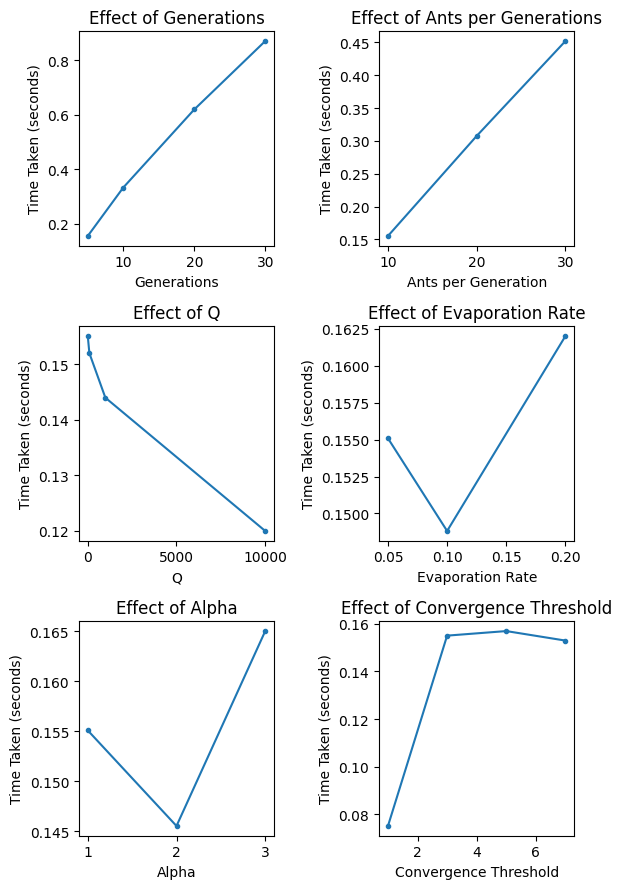

Plotting Effect on Performance


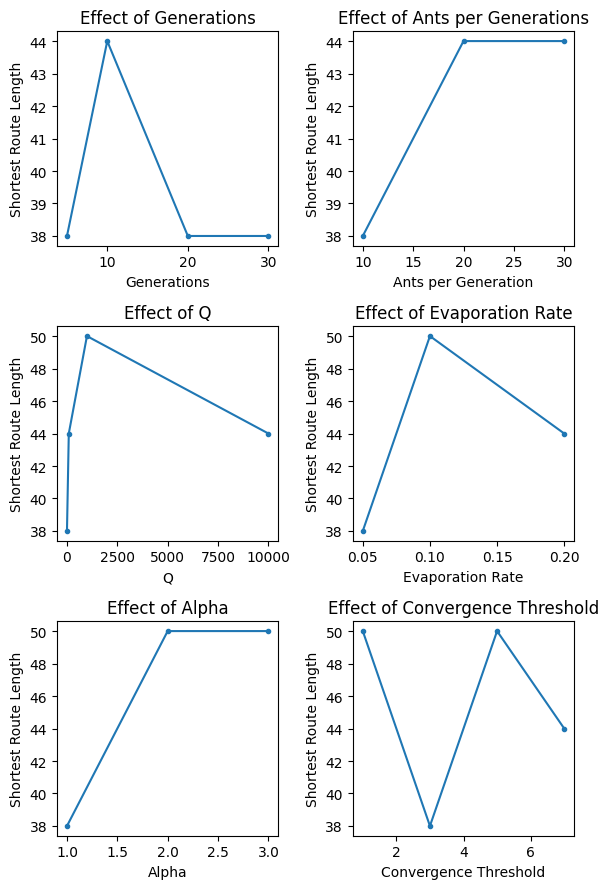

In [32]:
easy_route, param_indices = get_shortest_route_and_params(easy_results, gen_vals, ant_vals, q_vals, evap_vals, alpha_vals, conv_thresh_vals)
print("Best route length:", easy_route.size(), "\nBest Parameters:\n",
        f"generations: {gen_vals[param_indices[0]]}\n",
        f"ants per generation: {ant_vals[param_indices[1]]}\n",
        f"q: {q_vals[param_indices[2]]}\n",
        f"evaporation rate: {evap_vals[param_indices[3]]}\n",
        f"alpha:{alpha_vals[param_indices[4]]}\n",
        f"convergence threshold:{conv_thresh_vals[param_indices[5]]}"
      )
plot_hyperparam_effects(easy_results, param_indices, gen_vals, ant_vals, q_vals, evap_vals, alpha_vals, conv_thresh_vals, f=lambda x: x[1], ylabel="Time Taken (seconds)", title="Effect on Convergence")
plot_hyperparam_effects(easy_results, param_indices, gen_vals, ant_vals, q_vals, evap_vals, alpha_vals, conv_thresh_vals)

Best route length: 133 
Best Parameters:
 generations: 10
 ants per generation: 30
 q: 100
 evaporation rate: 0.05
 alpha:3
 convergence threshold:3
Plotting Effect on Convergence


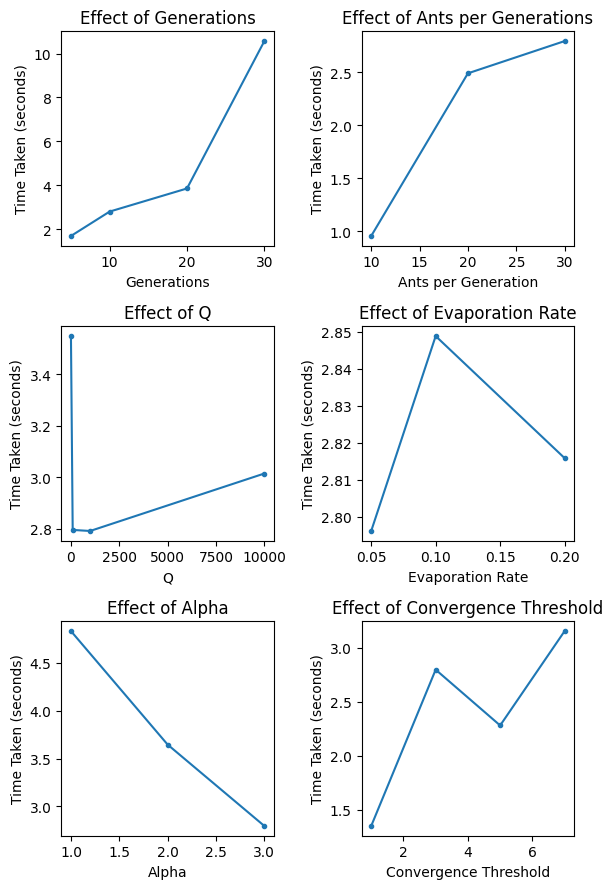

Plotting Effect on Performance


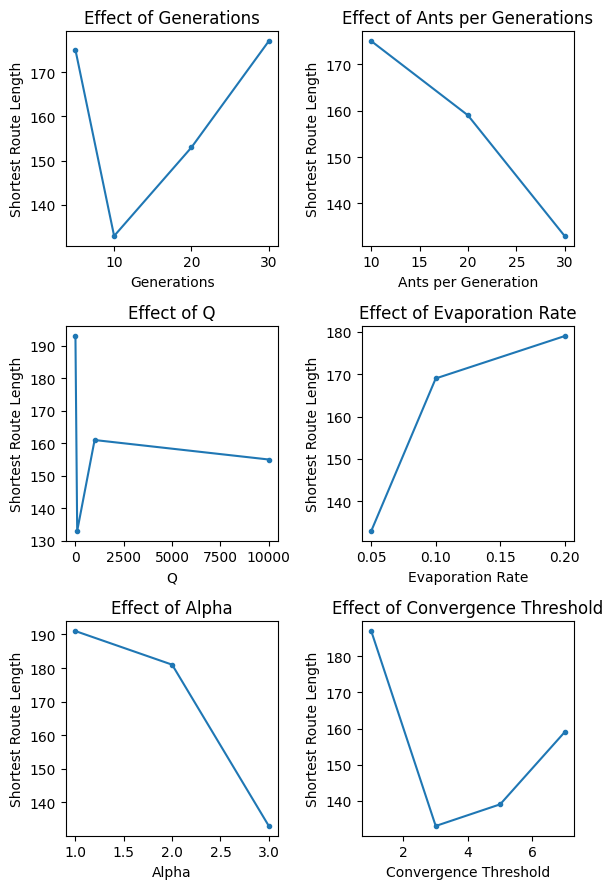

In [33]:
medium_route, param_indices = get_shortest_route_and_params(medium_results, gen_vals, ant_vals, q_vals, evap_vals, alpha_vals, conv_thresh_vals)
print("Best route length:", medium_route.size(), "\nBest Parameters:\n",
        f"generations: {gen_vals[param_indices[0]]}\n",
        f"ants per generation: {ant_vals[param_indices[1]]}\n",
        f"q: {q_vals[param_indices[2]]}\n",
        f"evaporation rate: {evap_vals[param_indices[3]]}\n",
        f"alpha:{alpha_vals[param_indices[4]]}\n",
        f"convergence threshold:{conv_thresh_vals[param_indices[5]]}"
      )
plot_hyperparam_effects(medium_results, param_indices, gen_vals, ant_vals, q_vals, evap_vals, alpha_vals, conv_thresh_vals, f=lambda x: x[1], ylabel="Time Taken (seconds)", title="Effect on Convergence")
plot_hyperparam_effects(medium_results, param_indices, gen_vals, ant_vals, q_vals, evap_vals, alpha_vals, conv_thresh_vals)

Best route length: 819 
Best Parameters:
 generations: 20
 ants per generation: 30
 q: 10000
 evaporation rate: 0.2
 alpha:3
 convergence threshold:3
Plotting Effect on Convergence


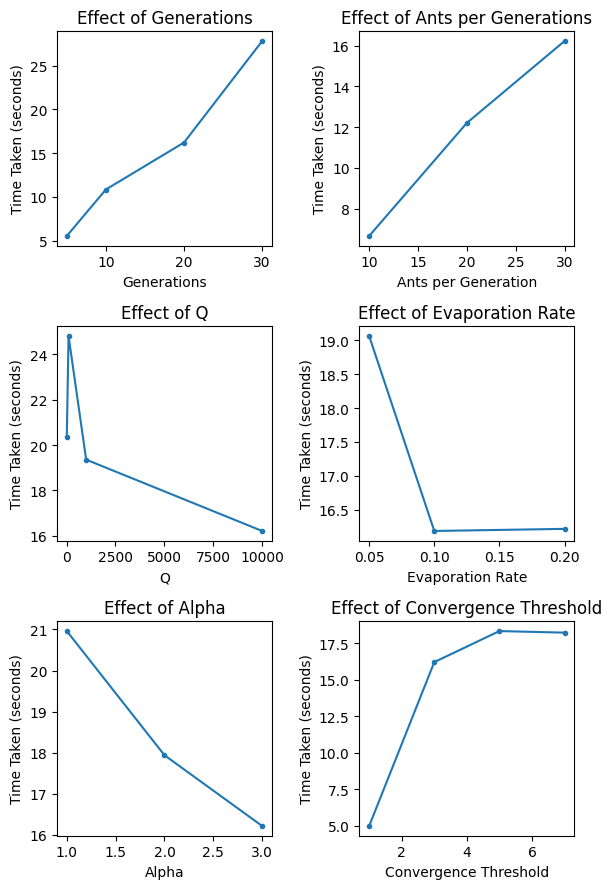

Plotting Effect on Performance


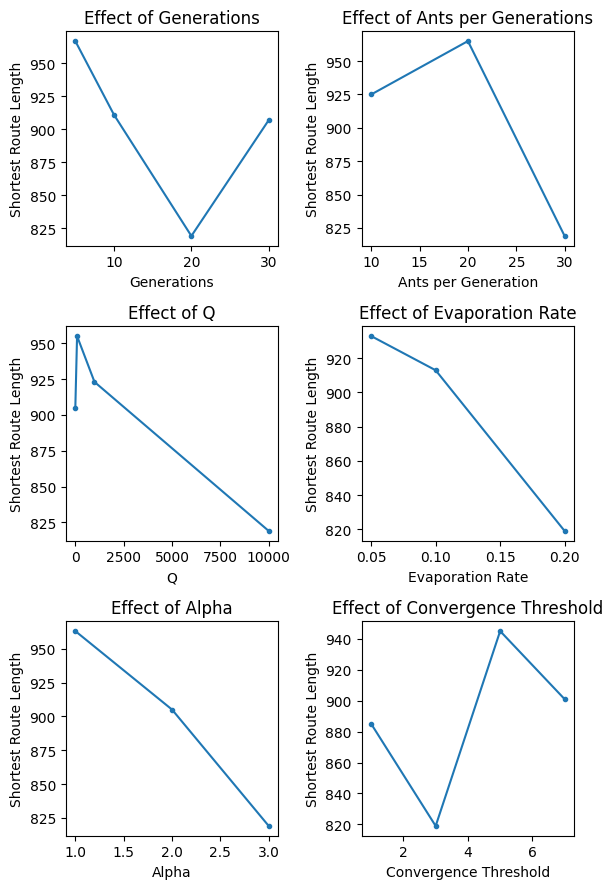

In [34]:
hard_route, param_indices = get_shortest_route_and_params(hard_results, gen_vals, ant_vals, q_vals, evap_vals, alpha_vals, conv_thresh_vals)
print("Best route length:", hard_route.size(), "\nBest Parameters:\n",
        f"generations: {gen_vals[param_indices[0]]}\n",
        f"ants per generation: {ant_vals[param_indices[1]]}\n",
        f"q: {q_vals[param_indices[2]]}\n",
        f"evaporation rate: {evap_vals[param_indices[3]]}\n",
        f"alpha:{alpha_vals[param_indices[4]]}\n",
        f"convergence threshold:{conv_thresh_vals[param_indices[5]]}"
      )
plot_hyperparam_effects(hard_results, param_indices, gen_vals, ant_vals, q_vals, evap_vals, alpha_vals, conv_thresh_vals, f=lambda x: x[1], ylabel="Time Taken (seconds)", title="Effect on Convergence")
plot_hyperparam_effects(hard_results, param_indices, gen_vals, ant_vals, q_vals, evap_vals, alpha_vals, conv_thresh_vals)

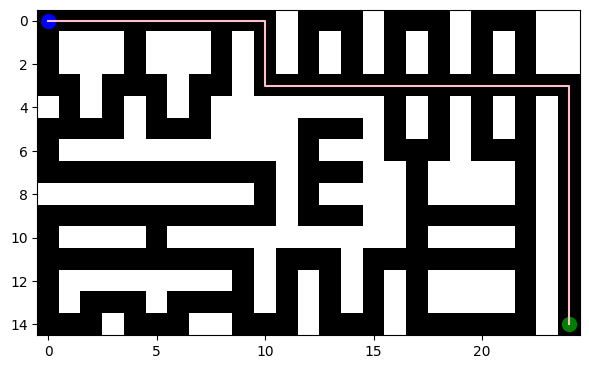

In [35]:
Visualizer.visualize_individual_path(easy_maze, easy_route, easy_spec)

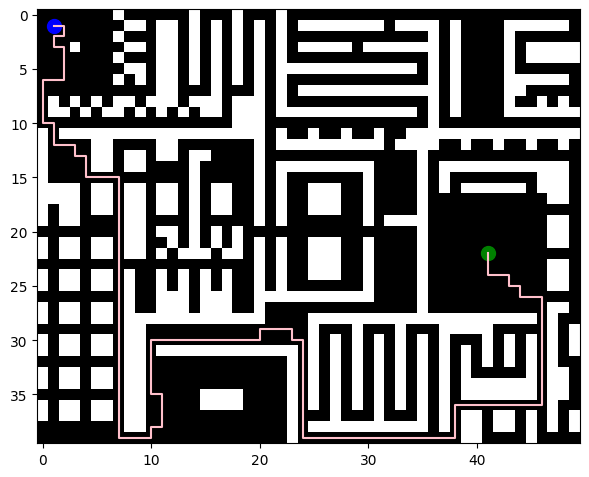

In [36]:
Visualizer.visualize_individual_path(medium_maze, medium_route, medium_spec)

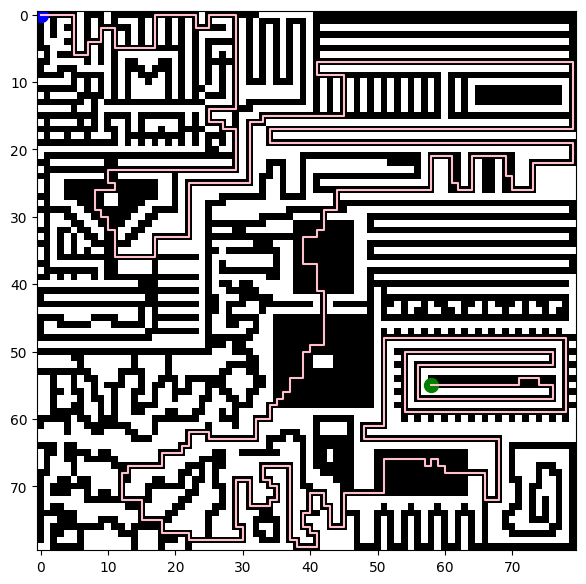

In [37]:
Visualizer.visualize_individual_path(hard_maze, hard_route, hard_spec)

<div style="background-color:#f1be3e">

#### Tuning Strategy
The tuning strategy employed here is grid-search. We start with lists of hyperparameter values that we want to use and then perform ACO with permutations of these values. This way of tuning our hyperparameter allows us to explore different combinations and find out which combination of parameters provide us with the best value, instead of tuning one parameter at a time.  

#### Best Hyperparameters
##### Easy Maze
Best route length: 38 
Best Parameters:
- generations: 5
- ants per generation: 10
- q: 10
- evaporation rate: 0.05
- alpha:1
- convergence threshold:3
 
##### Medium Maze
Best route length: 133 
Best Parameters:
- generations: 10
- ants per generation: 30
- q: 100
- evaporation rate: 0.05
- alpha:3
- convergence threshold:3
 
##### Hard Maze
 
Best route length: 819 
Best Parameters:
- generations: 20
- ants per generation: 30
- q: 10000
- evaporation rate: 0.2
- alpha:3
- convergence threshold:3
 
#### Impact of Hyperparameters
In order to isolate the impact of each hyperparameter, each plot we create changes a single hyperparameter while keeping the other hyperparameters at the best found values. For each maze, the first set of figures displays the impact of each hyperparameter to the time it takes for convergence. The second set of figures displays the impact of each hyperparameter on the shortest distance found.

##### Effects on Speed of Convergence
1. Generations: Adding more generations seems to increase the time it takes for our ACOs to run. This is could be explained as more iterations needing to take more time.
2. Ants per Generation: Adding more ants per generations also slows down our ACO. As more ants per generation means more time needed to run each generation, this makes a lot of sense.
3. Q: Each maze had a spike after its lowest value of q, and although the values tested were exponential, the highest value always converged the fastest. This seems to derive from the fact that a very low q means less pheromone is distributed along paths, so ants would tend to take the paths that lead them closer in terms of distance to the end destination. As we start adding a bit of pheromone, we get a spike because ants are now able to explore more paths thanks to more pheromone being distributed, although this does not always necessarily bring them closer to the end destination. At a certain point, a balance between exploration and exploitation is reached, and the ants can now reach the end destination faster than if they were to only consider the path that would bring them closest to the end. However, a q value that is too high reinforces the paths that have been taken too strongly, and we run into the same problem of ants sticking to the initial paths too much without much exploration.
4. Evaporation Rate: A larger evaporation rate seems to increase speed. A high evaporation rate gets rid of pheromones on less-traveled paths faster, causing our program to converge faster.
5. Alpha: Much like evaporation rate, alpha makes ants more likely to travel on more frequented paths, causing a faster convergence.
6. Convergence Threshold: A higher convergence threshold appears to decrease our speed of convergence. This makes sense, as it would make our requirements for convergence stricter.

##### Effects on Shortest Distance Found
1. Generations: Adding more generations seems to provide worse results for the easy maze. This is most likely due to the low complexity and small size of the maze, meaning once it gets to a near-optimal solution, adding more generations could end up creating more noise and therefore lead to worse results. As such, the mazes seem to have different optimal points for this hyperparameter. The medium maze got better results with 20 generations, while the hard maze needed 30 for its most optimal performance with the hyperparameters used in our search.
2. Ants per Generation: This hyperparameter seems to be affected by the complexity of the maze. Just like generations, it seems that there is an optimal point where after it is reached, any addition only results in extra noise (this is evident in the easy maze's results).
3. Q: As was the case with its impact on speed, this hyperparameter seems to spike after its initial value. Much like the explanation given earlier, this is believed to be due to the balance between exploration and exploitation of new paths. After all, without pheromones, an ant would very likely prefer taking 100 steps that decreases its distance to the end slowly with each step, than take 1 step that brings it farther from the end, but then allows it to take a shorter route that brings it closer to the end very rapidly. Of course, this depends on the complexity of the maze, as a q that is too high will just have the ants retaking the initial path most of the time, in turn causing early convergence that might not be optimal, as can be seen with the small maze.
4. Evaporation Rate: This hyperparameter seems to correlate well with the complexity of the maze. The small and medium mazes performed best with the lowest evaporation rate, while the large maze performed best with the highest evaporation rate. The evaporation rate determines how adaptable our ants are: low evaporation rate means slow adaptation, while high evaporation rate means ants are able to adapt and change routes quickly. In the small maze with little complexity, this low evaporation works as there aren't many paths to take to get to the end, whereas in larger and more complex mazes, ants need to be able to explore many more different routes in order to find the shortest route. 
5. Alpha: Larger mazes seem to work better with larger alphas. This may be due to how alpha exaggerates the difference of pheromone between paths, allowing the ACO to 'remember' the paths when the start and end distance is large to begin with.
6. Convergence Threshold: This hyperparameter seems to be the same for all mazes, and all 3 reached an optimum of 3.

#### Question 17

<div style="background-color:#f1be3e">

1. Generations: The easy maze got worse as more generations were added, while the medium and large mazes had an optimum in their U-shaped graphs. This might be due to the fact that as the size of the maze grows, the program has more routes to explore that lead to the end, necessitating further exploration. This means, large mazes need more generations to be able to explore all the possible routes.   
2. Ants per Generation: As was the case with generations, larger mazes require more ants per generation to be able to explore longer paths. More ants are needed to explore the medium and hard mazes, and thus they get better results as more ants per generation are used compared to the easy maze.
3. Q: The small maze performed best with the smallest Q value, the medium maze performed best with a larger Q value, while the hard maze performed better with a very large Q. As explained earlier, this is because the large maze has very long paths, and if Q was small, the amount of pheromone distributed in each segment of the path would be very small and therefore have very little effect. For the less complex mazes, however, having a Q that is too large causes ants to traverse through the initial path more often whilst rarely exploring new paths, as the Q for the segment of paths traversed through before becomes very large. This causes the program to get stuck at a minima.
4. Evaporation Rate: As was mentioned, the evaporation rate seems to share a relationship with the complexity of the maze. The more complex maze, hard, churned out better results with higher evaporation rates, as it requires faster adaptation to traverse through many paths compared to the easy and medium mazes. Higher evaporation rate allows for this faster adaptation, which explains this behavior.
5. Alpha: Larger mazes seem to work better with larger alphas. This could be a result of how alpha exaggerates the difference of pheromone between paths, allowing the ACO to 'remember' paths better especially since these mazes have large distances between start and end to begin with.
6. Convergence Threshold: There doesn't seem to be a pattern here, as all mazes reached an optimum of 3 and the graphs were very volatile.

### 2.6 The Final Route

#### Question 18

Easy Maze Solution


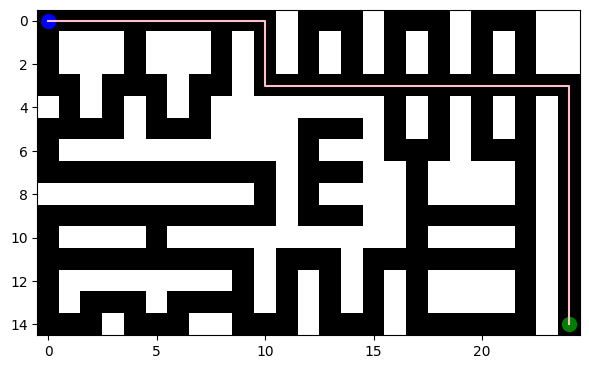

Medium Maze Solution


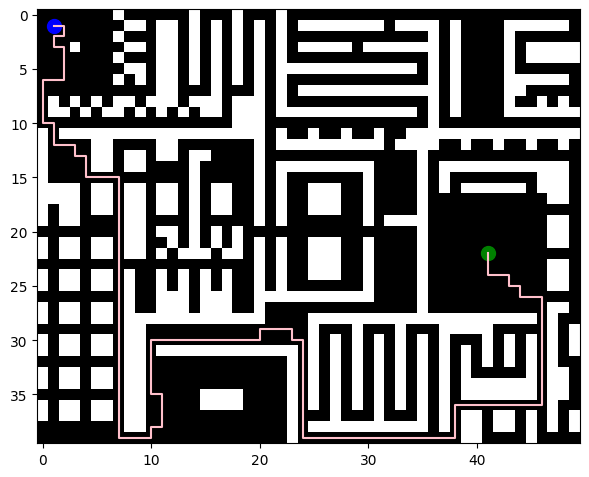

Hard Maze Solution


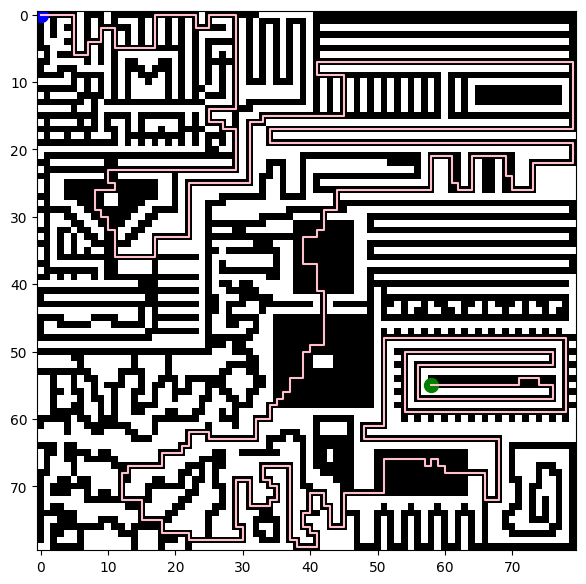

In [38]:
#Write routes to files
easy_route.write_to_file("./../data/58_easy.txt")
medium_route.write_to_file("./../data/58_medium.txt")
hard_route.write_to_file("./../data/58_hard.txt")

#visualize routes to check for correctness
print("Easy Maze Solution")
Visualizer.visualize_individual_path(easy_maze, easy_route, easy_spec)

print("Medium Maze Solution")
Visualizer.visualize_individual_path(medium_maze, medium_route, medium_spec)

print("Hard Maze Solution")
Visualizer.visualize_individual_path(hard_maze, hard_route, hard_spec)


<div style="background-color:#f1be3e">

The solutions have been written to the data folder in the specified format

### 2.7 Synthesis

#### Question 19

In [40]:
# Please keep your parameters for the synthesis part easily changeable here
gen = 20
no_gen = 30
q = 10000
evap = 0.2
alpha = 3
early_stop_threshold = 3

persist_file = "./../tmp/my_tsp"
tsp_path = "./../data/tsp_products.txt"
coordinates = "./../data/hard_coordinates.txt"

start_time = int(round(time.time() * 1000))
# Construct optimization
maze = Maze.create_maze("./../data/hard_maze.txt")
print("Time taken to create maze: " + str((int(round(time.time() * 1000)) - start_time) / 1000.0))

tsp_data = TSPData.read_specification(coordinates, tsp_path)
aco = IntelligentAntColonyOptimization(maze, generations=gen, ants_per_gen=no_gen, q=q, evaporation=evap, alpha=alpha, early_stop_threshold=early_stop_threshold)

print("Starting ACO")
start_time = int(round(time.time() * 1000))
# Run optimization and write to file
tsp_data.calculate_routes(aco)
tsp_data.write_to_file(persist_file)
print("Time taken to perform ACO: " + str((int(round(time.time() * 1000)) - start_time) / 1000.0))

# Read from file and print
tsp_data2 = TSPData.read_from_file(persist_file)
print(tsp_data == tsp_data2)

Ready reading maze file ./../data/hard_maze.txt
Time taken to create maze: 0.002
Starting ACO
Time taken to perform ACO: 2826.844
True
Initial distance: 4759.0
Final distance: 1461.0


In [66]:
population_size = 20
generations = 1000
p_crossover = 0.7
p_mutation = 0.01
elite_size = 3

# Create A GA 
ga = GeneticAlgorithm(generations, population_size, elite_size, p_crossover, p_mutation)

In [89]:
old_solutions = [ga.solve_tsp_visual(tsp_data) for x in tqdm(range(100))]
new_solutions = [ga.solve_tsp_visual(tsp_data2) for x in tqdm(range(100))]

  1%|          | 1/100 [00:00<00:12,  8.07it/s]

Initial distance: 4651.0
Final distance: 1343.0
Initial distance: 3857.0000000000005


  3%|▎         | 3/100 [00:00<00:14,  6.52it/s]

Final distance: 1343.0
Initial distance: 4301.0
Final distance: 1343.0
Initial distance: 4463.0


  5%|▌         | 5/100 [00:00<00:15,  6.13it/s]

Final distance: 2075.0
Initial distance: 4017.0
Final distance: 1343.0
Initial distance: 3382.9999999999995


  7%|▋         | 7/100 [00:01<00:14,  6.64it/s]

Final distance: 1343.0
Initial distance: 4123.0
Final distance: 1343.0
Initial distance: 3601.0


  9%|▉         | 9/100 [00:01<00:14,  6.45it/s]

Final distance: 1343.0
Initial distance: 4259.0
Final distance: 2075.0
Initial distance: 3949.0000000000005


 11%|█         | 11/100 [00:01<00:12,  6.98it/s]

Final distance: 1886.9999999999998
Initial distance: 3551.0
Final distance: 1343.0
Initial distance: 4303.0


 13%|█▎        | 13/100 [00:01<00:12,  7.23it/s]

Final distance: 1343.0
Initial distance: 4483.0
Final distance: 1343.0
Initial distance: 4267.0


 15%|█▌        | 15/100 [00:02<00:12,  6.98it/s]

Final distance: 1886.9999999999998
Initial distance: 4443.0
Final distance: 1343.0
Initial distance: 3987.0000000000005


 17%|█▋        | 17/100 [00:02<00:11,  7.15it/s]

Final distance: 1343.0
Initial distance: 3876.9999999999995
Final distance: 1343.0
Initial distance: 3940.9999999999995


 19%|█▉        | 19/100 [00:02<00:10,  7.45it/s]

Final distance: 1343.0
Initial distance: 4405.0
Final distance: 1343.0
Initial distance: 4169.0


 21%|██        | 21/100 [00:03<00:10,  7.60it/s]

Final distance: 1343.0
Initial distance: 4057.0000000000005
Final distance: 1343.0
Initial distance: 4129.0


 23%|██▎       | 23/100 [00:03<00:10,  7.10it/s]

Final distance: 1343.0
Initial distance: 4265.0
Final distance: 1343.0
Initial distance: 3445.0000000000005


 25%|██▌       | 25/100 [00:03<00:10,  7.38it/s]

Final distance: 1343.0
Initial distance: 3967.0
Final distance: 1343.0
Initial distance: 4549.0


 27%|██▋       | 27/100 [00:03<00:10,  7.13it/s]

Final distance: 1343.0
Initial distance: 4079.0000000000005
Final distance: 1343.0
Initial distance: 4311.0


 29%|██▉       | 29/100 [00:04<00:09,  7.15it/s]

Final distance: 1347.0
Initial distance: 4119.0
Final distance: 1343.0
Initial distance: 4411.0


 30%|███       | 30/100 [00:04<00:09,  7.27it/s]

Final distance: 1343.0
Initial distance: 3339.0


 32%|███▏      | 32/100 [00:04<00:11,  5.86it/s]

Final distance: 1343.0
Initial distance: 4065.0000000000005
Final distance: 1343.0


 33%|███▎      | 33/100 [00:04<00:10,  6.18it/s]

Initial distance: 4019.0
Final distance: 1343.0
Initial distance: 3914.9999999999995


 35%|███▌      | 35/100 [00:05<00:09,  6.61it/s]

Final distance: 1343.0
Initial distance: 4603.0
Final distance: 2035.0
Initial distance: 4081.0


 37%|███▋      | 37/100 [00:05<00:08,  7.04it/s]

Final distance: 1343.0
Initial distance: 3599.0000000000005
Final distance: 1343.0
Initial distance: 4451.0


 39%|███▉      | 39/100 [00:05<00:08,  7.07it/s]

Final distance: 1343.0
Initial distance: 3899.0000000000005
Final distance: 1343.0
Initial distance: 3693.0


 41%|████      | 41/100 [00:05<00:08,  7.04it/s]

Final distance: 1343.0
Initial distance: 3931.0
Final distance: 1343.0
Initial distance: 4429.0


 43%|████▎     | 43/100 [00:06<00:07,  7.42it/s]

Final distance: 1343.0
Initial distance: 3985.0000000000005
Final distance: 1343.0
Initial distance: 3725.0000000000005


 45%|████▌     | 45/100 [00:06<00:07,  7.35it/s]

Final distance: 1343.0
Initial distance: 3729.0
Final distance: 1343.0
Initial distance: 4241.0


 47%|████▋     | 47/100 [00:06<00:07,  7.31it/s]

Final distance: 1915.0
Initial distance: 4333.0
Final distance: 1343.0
Initial distance: 4355.0


 49%|████▉     | 49/100 [00:07<00:06,  7.48it/s]

Final distance: 2075.0
Initial distance: 3777.0
Final distance: 1343.0
Initial distance: 3373.0


 51%|█████     | 51/100 [00:07<00:06,  7.18it/s]

Final distance: 1343.0
Initial distance: 4017.0
Final distance: 1343.0
Initial distance: 4569.0


 53%|█████▎    | 53/100 [00:07<00:07,  6.67it/s]

Final distance: 1343.0
Initial distance: 4437.0
Final distance: 1343.0
Initial distance: 4529.0


 55%|█████▌    | 55/100 [00:07<00:06,  6.75it/s]

Final distance: 1521.0
Initial distance: 4441.0
Final distance: 1711.0
Initial distance: 4199.0


 57%|█████▋    | 57/100 [00:08<00:06,  6.98it/s]

Final distance: 1343.0
Initial distance: 4221.0
Final distance: 1343.0
Initial distance: 4475.0


 59%|█████▉    | 59/100 [00:08<00:05,  6.88it/s]

Final distance: 1343.0
Initial distance: 3848.9999999999995
Final distance: 1343.0
Initial distance: 3958.9999999999995


 61%|██████    | 61/100 [00:08<00:05,  6.58it/s]

Final distance: 1343.0
Initial distance: 4355.0
Final distance: 1343.0
Initial distance: 4661.0


 63%|██████▎   | 63/100 [00:09<00:05,  6.80it/s]

Final distance: 1343.0
Initial distance: 4187.0
Final distance: 1343.0
Initial distance: 4629.0


 65%|██████▌   | 65/100 [00:09<00:05,  6.80it/s]

Final distance: 1381.0
Initial distance: 3840.9999999999995
Final distance: 2028.9999999999998
Initial distance: 4483.0


 67%|██████▋   | 67/100 [00:09<00:04,  6.98it/s]

Final distance: 1343.0
Initial distance: 4283.0
Final distance: 1343.0
Initial distance: 4389.0


 69%|██████▉   | 69/100 [00:09<00:04,  7.21it/s]

Final distance: 1343.0
Initial distance: 4233.0
Final distance: 1343.0
Initial distance: 4179.0


 71%|███████   | 71/100 [00:10<00:04,  7.20it/s]

Final distance: 1729.0000000000002
Initial distance: 4537.0
Final distance: 2075.0
Initial distance: 4273.0


 73%|███████▎  | 73/100 [00:10<00:03,  7.29it/s]

Final distance: 1343.0
Initial distance: 4279.0
Final distance: 1343.0
Initial distance: 3875.0


 75%|███████▌  | 75/100 [00:10<00:03,  7.50it/s]

Final distance: 1343.0
Initial distance: 4165.0
Final distance: 1343.0
Initial distance: 3955.0


 77%|███████▋  | 77/100 [00:11<00:03,  7.52it/s]

Final distance: 1343.0
Initial distance: 4057.0000000000005
Final distance: 1343.0
Initial distance: 3983.0


 79%|███████▉  | 79/100 [00:11<00:02,  7.60it/s]

Final distance: 1343.0
Initial distance: 4697.0
Final distance: 1886.9999999999998
Initial distance: 4609.0


 81%|████████  | 81/100 [00:11<00:02,  7.42it/s]

Final distance: 1343.0
Initial distance: 3745.0
Final distance: 1343.0
Initial distance: 4495.0


 82%|████████▏ | 82/100 [00:11<00:02,  6.86it/s]

Final distance: 1343.0
Initial distance: 3662.9999999999995


 84%|████████▍ | 84/100 [00:12<00:02,  5.95it/s]

Final distance: 1387.0
Initial distance: 3439.0
Final distance: 1343.0
Initial distance: 4085.0


 86%|████████▌ | 86/100 [00:12<00:02,  6.65it/s]

Final distance: 1343.0
Initial distance: 4081.0
Final distance: 1343.0
Initial distance: 4103.0


 88%|████████▊ | 88/100 [00:12<00:01,  6.70it/s]

Final distance: 2075.0
Initial distance: 4287.0
Final distance: 1897.0
Initial distance: 4599.0


 90%|█████████ | 90/100 [00:12<00:01,  6.56it/s]

Final distance: 1343.0
Initial distance: 3477.0000000000005
Final distance: 1343.0
Initial distance: 3972.9999999999995


 92%|█████████▏| 92/100 [00:13<00:01,  6.07it/s]

Final distance: 1897.0
Initial distance: 4403.0
Final distance: 1703.0
Initial distance: 4109.0


 94%|█████████▍| 94/100 [00:13<00:00,  6.38it/s]

Final distance: 1343.0
Initial distance: 4187.0
Final distance: 1343.0
Initial distance: 3995.0000000000005


 96%|█████████▌| 96/100 [00:13<00:00,  6.78it/s]

Final distance: 1343.0
Initial distance: 4699.0
Final distance: 1343.0
Initial distance: 4515.0


 98%|█████████▊| 98/100 [00:14<00:00,  6.94it/s]

Final distance: 1343.0
Initial distance: 3673.0
Final distance: 1343.0
Initial distance: 3845.0


100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Final distance: 1343.0
Initial distance: 3919.0
Final distance: 1343.0


  0%|          | 0/100 [00:00<?, ?it/s]

Initial distance: 5241.0


  1%|          | 1/100 [00:00<00:13,  7.52it/s]

Final distance: 1917.0
Initial distance: 4803.0


  2%|▏         | 2/100 [00:00<00:13,  7.17it/s]

Final distance: 2001.0
Initial distance: 4509.0


  3%|▎         | 3/100 [00:00<00:13,  7.31it/s]

Final distance: 1401.0
Initial distance: 4613.0


  4%|▍         | 4/100 [00:00<00:13,  7.22it/s]

Final distance: 1383.0
Initial distance: 5101.0


  5%|▌         | 5/100 [00:00<00:13,  7.08it/s]

Final distance: 1533.0
Initial distance: 4293.0


  6%|▌         | 6/100 [00:00<00:13,  7.15it/s]

Final distance: 1383.0
Initial distance: 4123.0


  7%|▋         | 7/100 [00:00<00:13,  7.08it/s]

Final distance: 1401.0
Initial distance: 4803.0


  8%|▊         | 8/100 [00:01<00:12,  7.22it/s]

Final distance: 1880.9999999999998
Initial distance: 4669.0


  9%|▉         | 9/100 [00:01<00:12,  7.28it/s]

Final distance: 1383.0
Initial distance: 4971.0


 10%|█         | 10/100 [00:01<00:12,  7.20it/s]

Final distance: 2207.0
Initial distance: 5341.0


 11%|█         | 11/100 [00:01<00:12,  7.17it/s]

Final distance: 2171.0
Initial distance: 4111.0


 12%|█▏        | 12/100 [00:01<00:12,  7.19it/s]

Final distance: 1401.0
Initial distance: 4353.0


 13%|█▎        | 13/100 [00:01<00:11,  7.27it/s]

Final distance: 1771.0000000000002
Initial distance: 4963.0


 14%|█▍        | 14/100 [00:01<00:12,  6.94it/s]

Final distance: 1529.0
Initial distance: 4641.0


 15%|█▌        | 15/100 [00:02<00:12,  6.97it/s]

Final distance: 2363.0
Initial distance: 4409.0


 16%|█▌        | 16/100 [00:02<00:11,  7.01it/s]

Final distance: 1978.9999999999998
Initial distance: 4361.0


 17%|█▋        | 17/100 [00:02<00:12,  6.87it/s]

Final distance: 1401.0
Initial distance: 4847.0


 18%|█▊        | 18/100 [00:02<00:12,  6.69it/s]

Final distance: 1383.0
Initial distance: 4391.0


 19%|█▉        | 19/100 [00:02<00:12,  6.73it/s]

Final distance: 1383.0
Initial distance: 5081.0


 20%|██        | 20/100 [00:02<00:11,  6.76it/s]

Final distance: 1978.9999999999998
Initial distance: 5273.0


 21%|██        | 21/100 [00:02<00:11,  6.82it/s]

Final distance: 1461.0
Initial distance: 4907.0


 22%|██▏       | 22/100 [00:03<00:11,  6.74it/s]

Final distance: 1461.0
Initial distance: 4071.0


 23%|██▎       | 23/100 [00:03<00:11,  6.61it/s]

Final distance: 1401.0
Initial distance: 4839.0


 24%|██▍       | 24/100 [00:03<00:11,  6.60it/s]

Final distance: 1791.0
Initial distance: 5497.0


 25%|██▌       | 25/100 [00:03<00:11,  6.58it/s]

Final distance: 1383.0
Initial distance: 5455.0


 26%|██▌       | 26/100 [00:03<00:10,  6.81it/s]

Final distance: 1401.0
Initial distance: 4965.0


 27%|██▋       | 27/100 [00:03<00:11,  6.54it/s]

Final distance: 2211.0
Initial distance: 4957.0


 28%|██▊       | 28/100 [00:04<00:10,  6.75it/s]

Final distance: 1871.0000000000002
Initial distance: 4067.0


 29%|██▉       | 29/100 [00:04<00:10,  6.70it/s]

Final distance: 2009.0
Initial distance: 4183.0


 30%|███       | 30/100 [00:04<00:10,  6.55it/s]

Final distance: 1987.0
Initial distance: 4545.0


 32%|███▏      | 32/100 [00:04<00:11,  5.70it/s]

Final distance: 1978.9999999999998
Initial distance: 4867.0
Final distance: 1383.0


 33%|███▎      | 33/100 [00:04<00:10,  6.10it/s]

Initial distance: 3597.0
Final distance: 1771.0000000000002
Initial distance: 4977.0


 35%|███▌      | 35/100 [00:05<00:10,  6.27it/s]

Final distance: 1383.0
Initial distance: 5219.0
Final distance: 1401.0
Initial distance: 5285.0


 37%|███▋      | 37/100 [00:05<00:09,  6.67it/s]

Final distance: 1401.0
Initial distance: 4763.0
Final distance: 1481.0
Initial distance: 5015.0


 39%|███▉      | 39/100 [00:05<00:08,  7.09it/s]

Final distance: 1971.0
Initial distance: 4581.0
Final distance: 1401.0
Initial distance: 5007.0


 41%|████      | 41/100 [00:06<00:08,  6.97it/s]

Final distance: 2149.0
Initial distance: 3958.9999999999995
Final distance: 1965.0
Initial distance: 4811.0


 43%|████▎     | 43/100 [00:06<00:08,  6.83it/s]

Final distance: 1771.0000000000002
Initial distance: 4311.0
Final distance: 1383.0
Initial distance: 3968.9999999999995


 45%|████▌     | 45/100 [00:06<00:07,  7.04it/s]

Final distance: 1401.0
Initial distance: 5053.0
Final distance: 1383.0
Initial distance: 4373.0


 47%|████▋     | 47/100 [00:06<00:07,  7.26it/s]

Final distance: 1383.0
Initial distance: 4491.0
Final distance: 1743.0000000000002
Initial distance: 4313.0


 49%|████▉     | 49/100 [00:07<00:07,  7.15it/s]

Final distance: 1401.0
Initial distance: 4819.0
Final distance: 2151.0
Initial distance: 5025.0


 51%|█████     | 51/100 [00:07<00:06,  7.04it/s]

Final distance: 1461.0
Initial distance: 5419.0
Final distance: 1383.0
Initial distance: 5767.0


 53%|█████▎    | 53/100 [00:07<00:06,  7.02it/s]

Final distance: 2541.0
Initial distance: 4993.0
Final distance: 1383.0
Initial distance: 3943.0


 55%|█████▌    | 55/100 [00:08<00:06,  7.07it/s]

Final distance: 1383.0
Initial distance: 4935.0
Final distance: 2151.0
Initial distance: 4635.0


 57%|█████▋    | 57/100 [00:08<00:05,  7.33it/s]

Final distance: 1383.0
Initial distance: 3995.0000000000005
Final distance: 1383.0
Initial distance: 4991.0


 59%|█████▉    | 59/100 [00:08<00:05,  6.89it/s]

Final distance: 1401.0
Initial distance: 5065.0
Final distance: 1875.0
Initial distance: 4511.0


 61%|██████    | 61/100 [00:08<00:05,  7.28it/s]

Final distance: 1383.0
Initial distance: 4731.0
Final distance: 1383.0
Initial distance: 4067.0


 63%|██████▎   | 63/100 [00:09<00:05,  6.98it/s]

Final distance: 1383.0
Initial distance: 5207.0
Final distance: 2153.0
Initial distance: 4653.0


 65%|██████▌   | 65/100 [00:09<00:04,  7.30it/s]

Final distance: 2375.0
Initial distance: 4655.0
Final distance: 1817.0
Initial distance: 4275.0


 67%|██████▋   | 67/100 [00:09<00:04,  7.31it/s]

Final distance: 1935.0000000000002
Initial distance: 5165.0
Final distance: 1401.0
Initial distance: 4571.0


 69%|██████▉   | 69/100 [00:09<00:04,  7.52it/s]

Final distance: 1401.0
Initial distance: 4715.0
Final distance: 1817.0
Initial distance: 5217.0


 71%|███████   | 71/100 [00:10<00:03,  7.47it/s]

Final distance: 2633.0
Initial distance: 5043.0
Final distance: 1771.0000000000002
Initial distance: 4643.0


 73%|███████▎  | 73/100 [00:10<00:03,  7.64it/s]

Final distance: 1401.0
Initial distance: 4293.0
Final distance: 1401.0
Initial distance: 4945.0


 75%|███████▌  | 75/100 [00:10<00:03,  7.52it/s]

Final distance: 1935.0000000000002
Initial distance: 4289.0
Final distance: 2349.0
Initial distance: 4579.0


 77%|███████▋  | 77/100 [00:11<00:03,  7.60it/s]

Final distance: 1383.0
Initial distance: 5327.0
Final distance: 1383.0
Initial distance: 4457.0


 79%|███████▉  | 79/100 [00:11<00:02,  7.52it/s]

Final distance: 1383.0
Initial distance: 4591.0
Final distance: 1383.0
Initial distance: 4603.0


 81%|████████  | 81/100 [00:11<00:02,  7.73it/s]

Final distance: 1401.0
Initial distance: 4603.0
Final distance: 1383.0
Initial distance: 4841.0


 83%|████████▎ | 83/100 [00:11<00:02,  7.20it/s]

Final distance: 1383.0
Initial distance: 5049.0
Final distance: 2151.0
Initial distance: 3895.0


 85%|████████▌ | 85/100 [00:12<00:02,  7.41it/s]

Final distance: 1401.0
Initial distance: 5245.0
Final distance: 1383.0
Initial distance: 4883.0


 87%|████████▋ | 87/100 [00:12<00:01,  7.52it/s]

Final distance: 1807.0000000000002
Initial distance: 4771.0
Final distance: 1791.0
Initial distance: 3765.0


 89%|████████▉ | 89/100 [00:12<00:01,  7.22it/s]

Final distance: 1955.0000000000002
Initial distance: 5349.0
Final distance: 1383.0
Initial distance: 5223.0


 91%|█████████ | 91/100 [00:13<00:01,  5.78it/s]

Final distance: 1791.0
Initial distance: 5107.0
Final distance: 1935.0000000000002


 92%|█████████▏| 92/100 [00:13<00:01,  6.33it/s]

Initial distance: 4923.0
Final distance: 1383.0
Initial distance: 4611.0


 94%|█████████▍| 94/100 [00:13<00:00,  6.89it/s]

Final distance: 1383.0
Initial distance: 4459.0
Final distance: 1797.0
Initial distance: 5147.0


 96%|█████████▌| 96/100 [00:13<00:00,  7.05it/s]

Final distance: 1383.0
Initial distance: 5135.0
Final distance: 1401.0
Initial distance: 4917.0


 98%|█████████▊| 98/100 [00:14<00:00,  7.20it/s]

Final distance: 1383.0
Initial distance: 4779.0
Final distance: 2115.0
Initial distance: 5171.0


100%|██████████| 100/100 [00:14<00:00,  7.00it/s]

Final distance: 1401.0
Initial distance: 4307.0
Final distance: 1935.0000000000002


In [90]:
print("Average Distance found through Old TSP:", np.mean([x[1][-1] for x in old_solutions]))
print("Average Distance found through New TSP:", np.mean([x[1][-1] for x in new_solutions]))

Average Distance found through Old TSP: 1440.28
Average Distance found through New TSP: 1660.86


Initial distance: 4125.0
Final distance: 2121.0


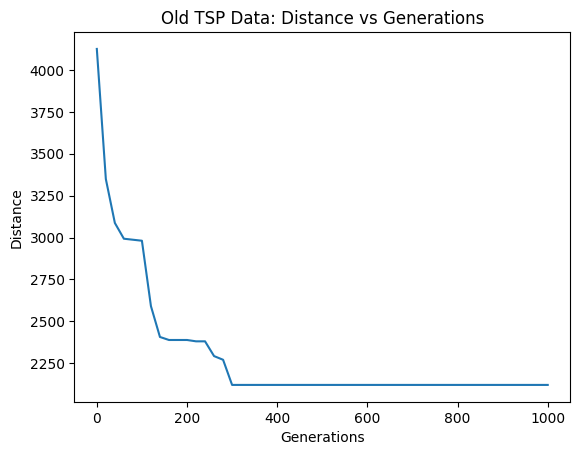

Initial distance: 4841.0
Final distance: 1461.0


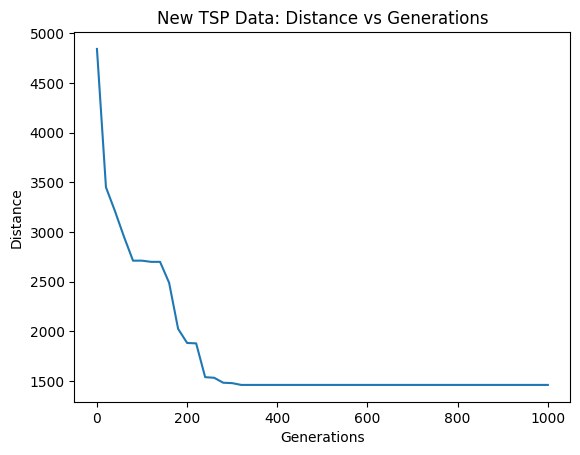

In [71]:
old_solution, distances = ga.solve_tsp_visual(tsp_data)

plt.plot(range(0, 1001, 20), distances)
plt.xlabel("Generations")
plt.ylabel("Distance")
plt.title("Old TSP Data: Distance vs Generations")
plt.show()

new_solution, distances = ga.solve_tsp_visual(tsp_data2) 

plt.plot(range(0, 1001, 20), distances)
plt.xlabel("Generations")
plt.ylabel("Distance")
plt.title("New TSP Data: Distance vs Generations")
plt.show()

tsp_data2.write_action_file(new_solution, "./../data/58_actions_TSP.txt")

In [72]:
print("Old Order:", [x+1 for x in old_solution])
print("New Order:", [x+1 for x in new_solution])

Old Order: [1, 2, 7, 5, 14, 13, 6, 3, 11, 15, 10, 9, 16, 4, 8, 18, 12, 17]
New Order: [1, 2, 7, 5, 14, 16, 4, 8, 18, 10, 9, 15, 12, 13, 6, 11, 3, 17]


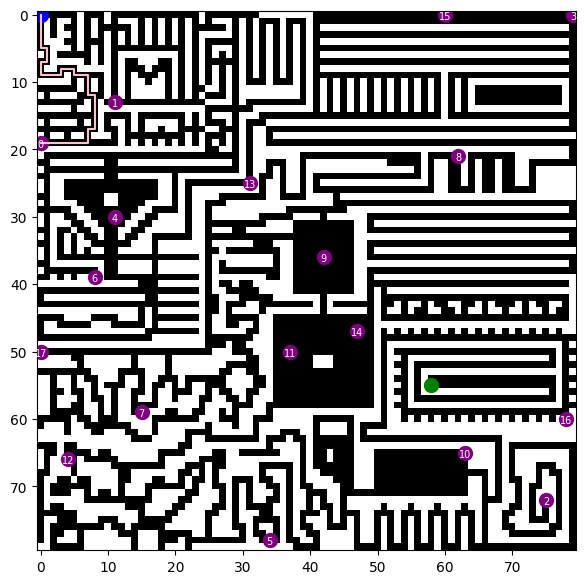

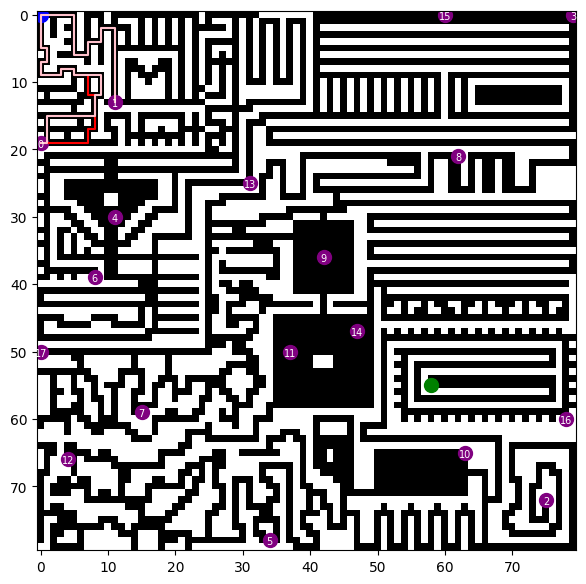

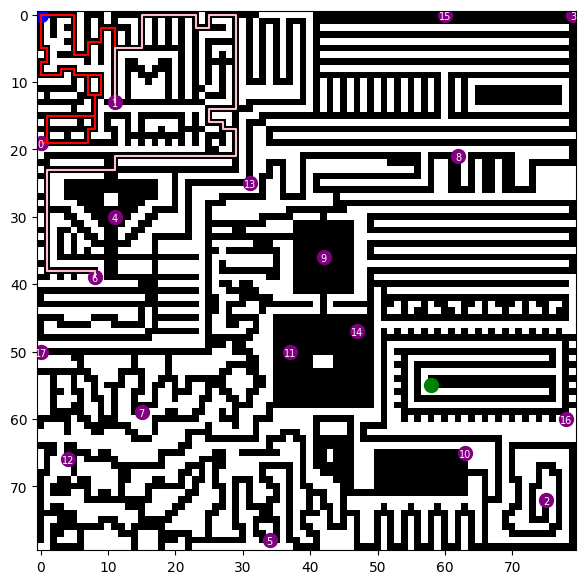

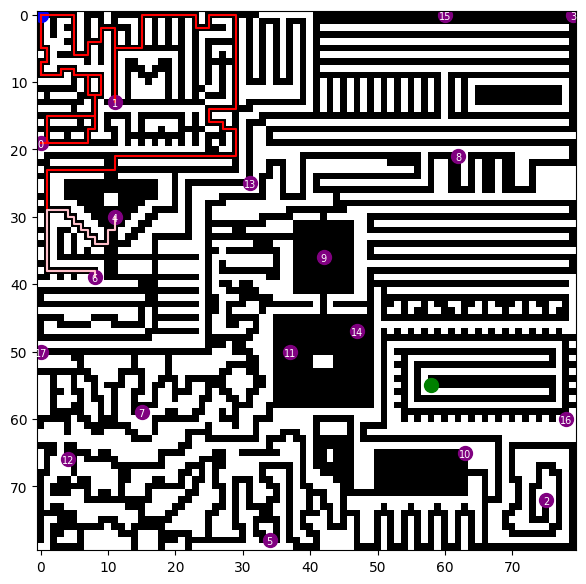

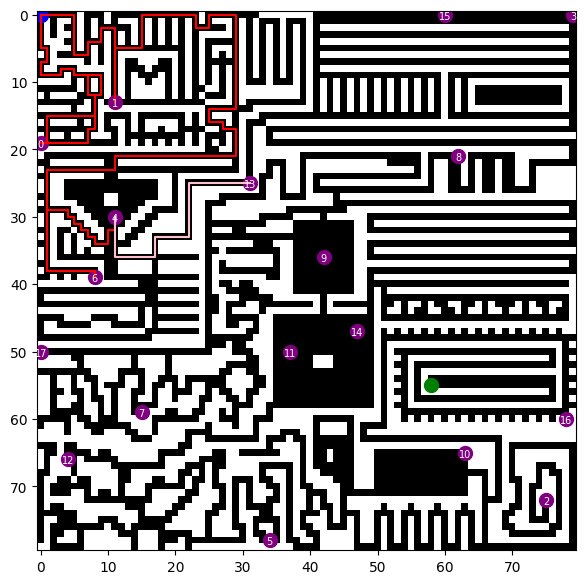

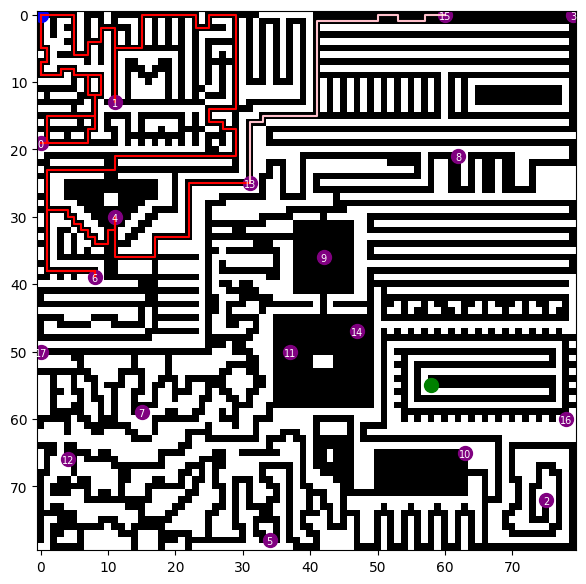

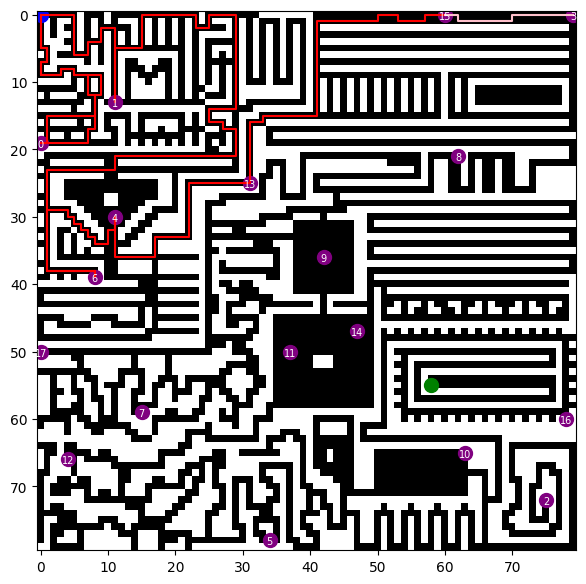

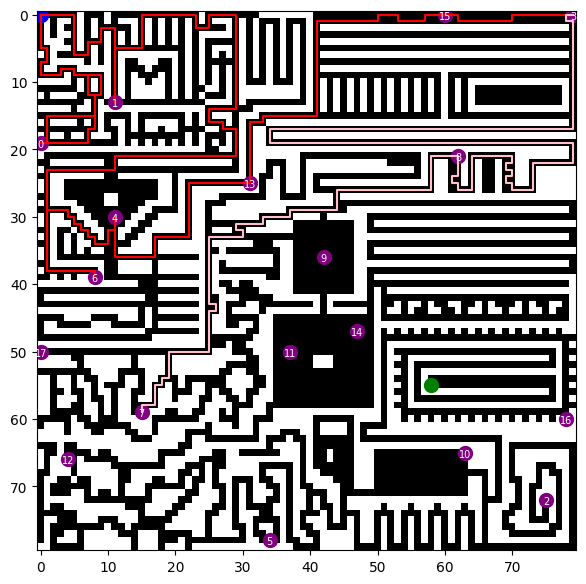

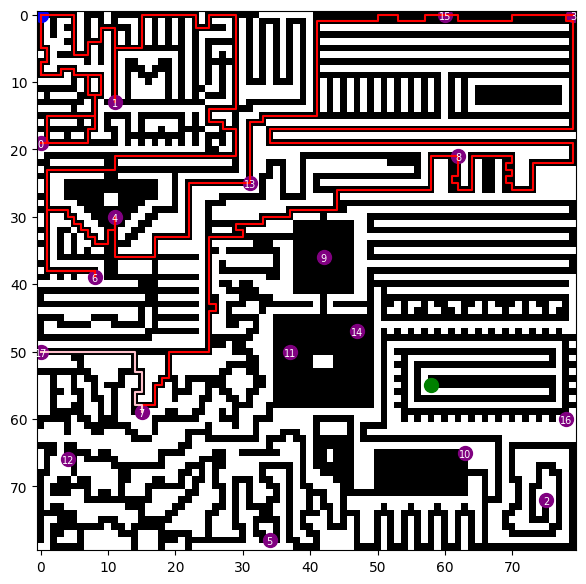

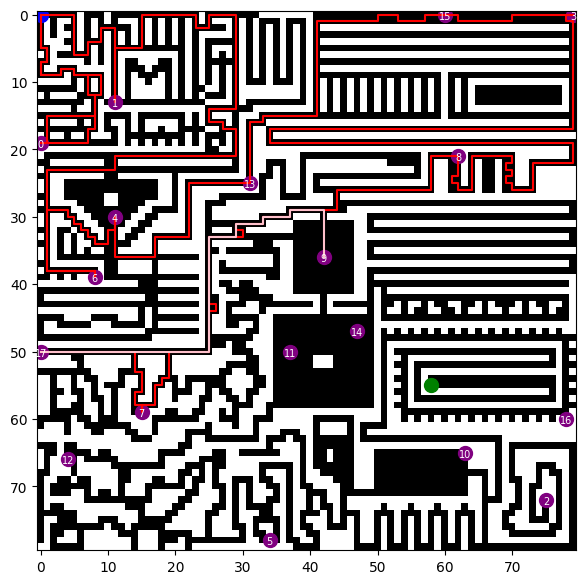

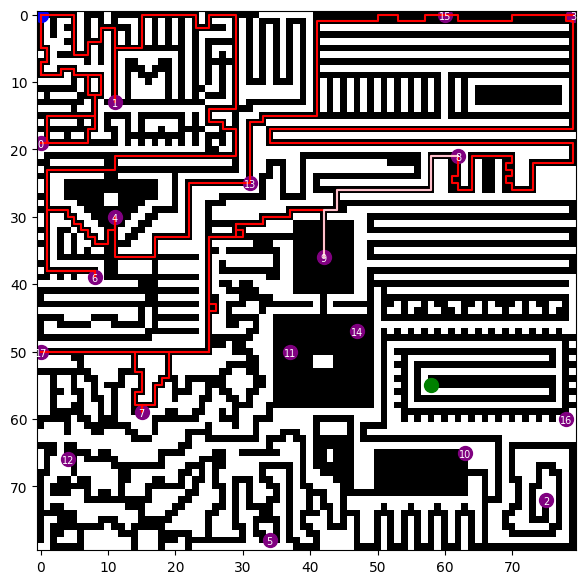

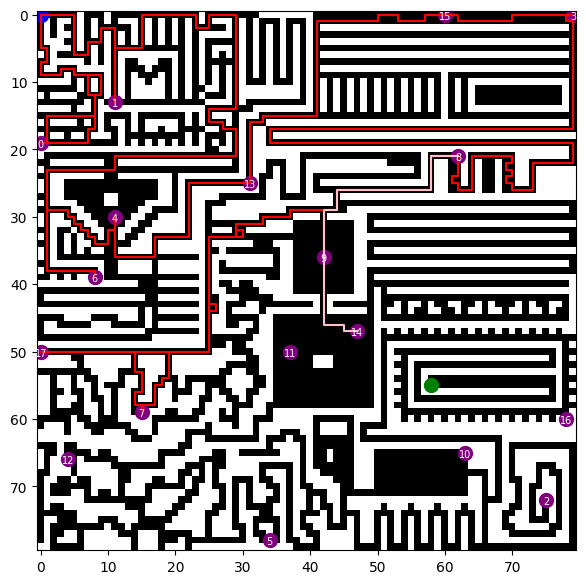

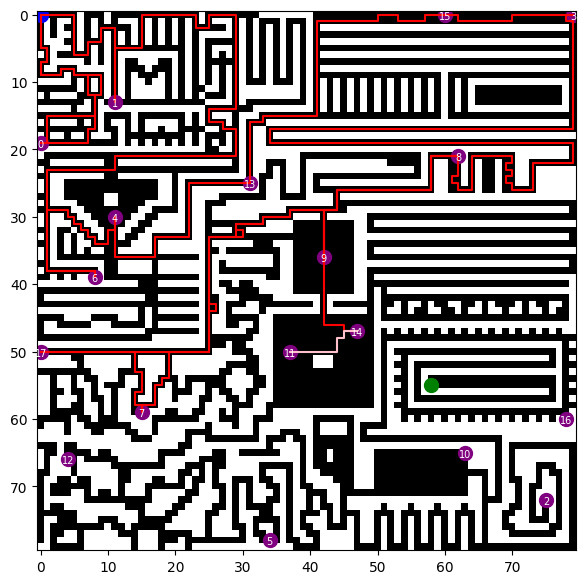

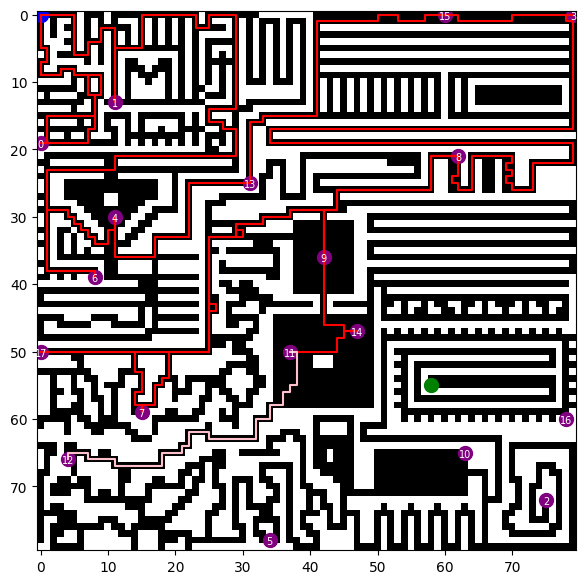

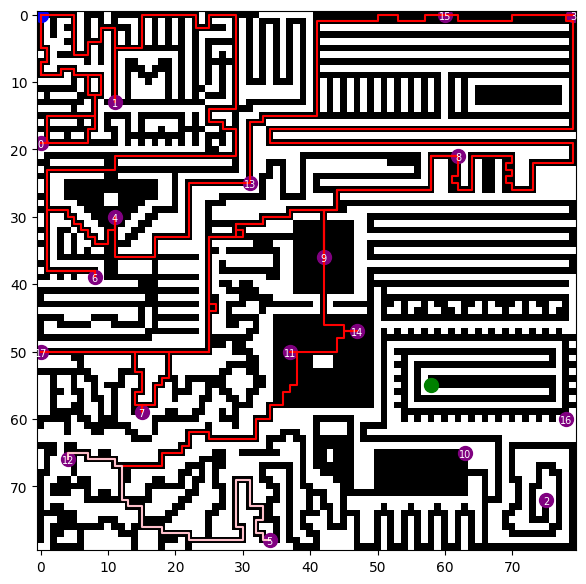

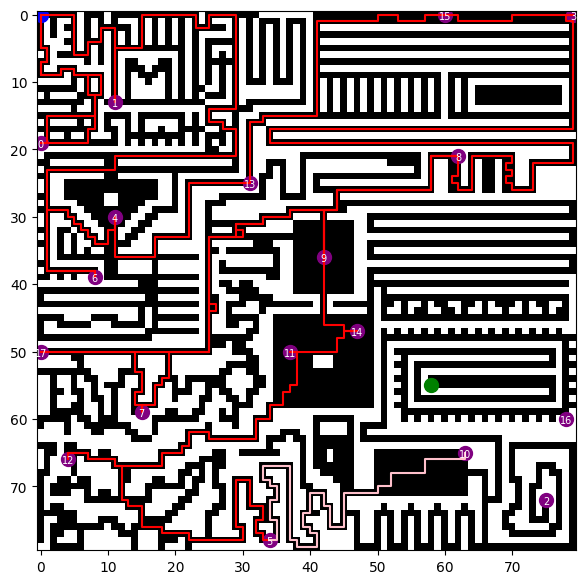

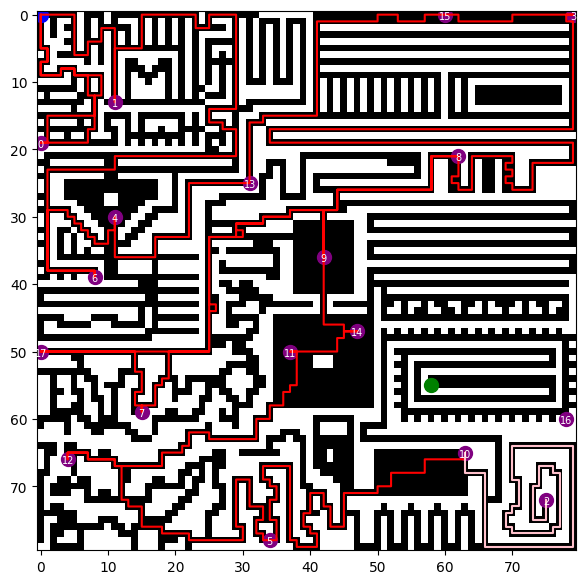

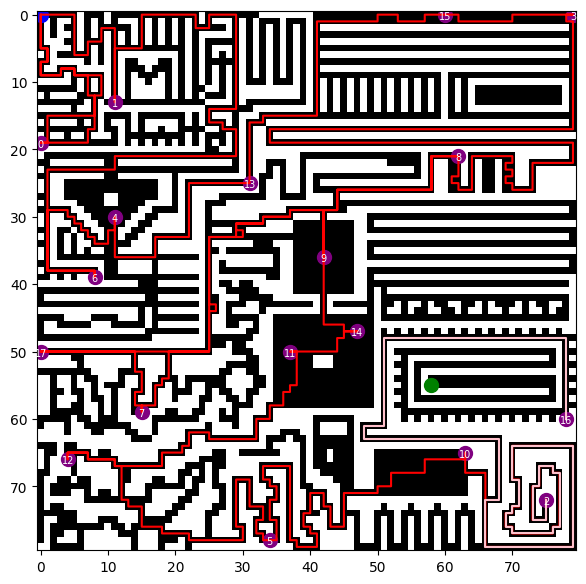

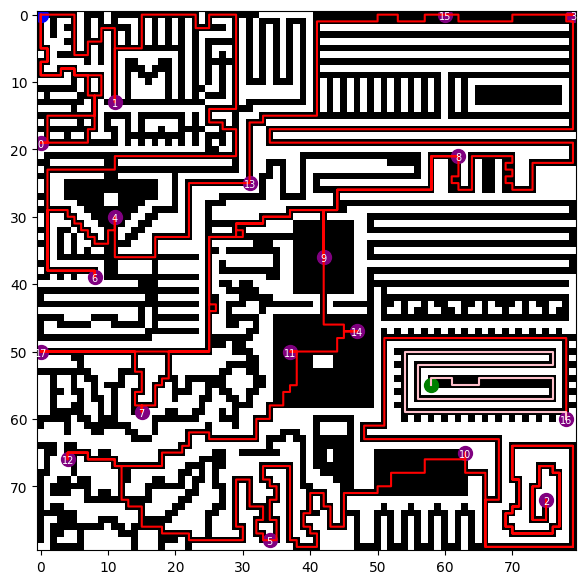

In [74]:
Visualizer.visualize_tsp_solution_paths(maze, new_solution, tsp_data2)

<div style="background-color:#f1be3e">

Our solution had a better length and order of items than the one found in the algorithm in Part 1. Although this seems to indicate that we had found a better tsp_data, this is not the case. Averaging the results over 100 tries reveals that optimal_tsp performs better on average than our solution.

This could be due to the fact that we have tuned our hyperparameters in accordance to just one end and start point, while in reality we have 18*18 paths with different start and end points to calculate when running our ACO. A way to solve this might be to tune our hyperparameters by considering performance across multiple paths, and not just one pair.


## Part 3: Open Questions
### 3.1 Reflection

#### Question 20

<div style="background-color:#f1be3e">

An example would be Multi-Objective problems. Since there could be multiple "Optimal" solutions. Where increasing a certain variable could decrease another. So there could be a trade-off where we might optimise certain variables but not others. So it would be harder to find a fitness function since there are many different variables that could impact one another. An example could be trying to optimise a car, since there are many variables that need to keep account of for example, size, tank size, shape, etc...

#### Question 21

<div style="background-color:#f1be3e">

This would not be optimal since there is the possibility of getting stuck in a local maximum and there would be less variation in the population which makes discovering new solutions by having new mutations harder to escape the local maximum. So there is also the idea of overfitting since the genetic algorithm could give a set of solutions that won't work optimally for unseen scenario's. This could be combatted by not only taking the strongest individual but the top few individuals. Since there would be more varierty in the genepool for finding possibly better solutions

### 3.2 Pen and Paper

#### Question 22

<div style="background-color:#f1be3e">

![Plot](<./q22_plot.jpg>)
Since we are trying to optimize for two variables this is a multi-objective problem. Our robot attempts to select the best set of foods based on their price, thus we will probably try to minimize the price, and maximize the nutritional value. 

There are 2 points that are not dominated by any other points, that are the points on coordinates (3, 9) and (1, 6) (A and E in the plot). We will always want to choose these products as they make up the non-dominated front one "line", they are the pareto frontiers. 
If our robot can carry only 4 things we will also need to look at the second front, since our first front only has 2 items. The second front has more than 2 points, thus we can not choose all points in the second front, that would result in more than 4 products total. We will use crowding distance to determine which points from the second front to keep. 
The formulas for crowding distance are:
$$
CD_{im} = \frac{f_m(x_{i+1}) - f_m(x_{i-1})} {f_m(x_{max}) - f_m(x_{min})}
$$

$$
CD_i = \sum^m_{m=1} CD_{im} 
$$

 &nbsp;
 in the table we can see the $x_{max}$, $x_{min}$ and the difference between the two. We will use the diff as the denominator in the $CD_{im}$ formula.
 
|                   | max | min | diff |
|-------------------|-----|-----|------|
| price             | 9   | 1   | 8    |
| nutrational value | 9   | 1   | 8    |

&nbsp;

The crowding distance for the points on the second front are, from left to right: 
$$
CD_B = \infty \\
CD_C = \frac{8 - 4}{8} + \frac{7-2}{8} = 1.125 \\ 
CD_G = \frac{7-1}{8} + \frac{4-1}{8} = 1.125 \\
CD_J = \infty
$$

We want to use the points with higher crowding distances, to keep more variety in our population. Thus we keep point B and point J, since they have the highest crowding distance of the 4 points in the second front. Hence the robot will choose A, E, B and J as the 4 products. 

#### Question 23

<div style="background-color:#f1be3e">

Overview PSO and Daily Caloric Intake Formulas:
$$
v_{ij}(t) = v_{ij}(t) + c_{1}r_{1j}(t)[y_{ij}(t) - x_{ij}(t)] + c_{2}r_{2j}(t)[\hat{y}(t) - x_{ij}(t)]\\
x_{i}(t+1) = x_{i}(t) + v_{i}(t+1)\\
C(w,h) = 20w + 70h - wh + 500\\
$$
Initial local best solution is $y_{i}(0) = x_{i}(0)$

Calculating $f(y_{i}(0))$ and ŷ at timestamp 0:
$$
f(y_{1}(0)): C(85, 1.9) = 20 * 85 + 70 * 1.9 - 85 * 1.9 + 500 = 2171.5\\
f(y_{2}(0)): C(60, 1.6) = 20 * 60 + 70 * 1.6 - 60 * 1.6 + 500 = 1716.0\\
f(y_{3}(0)): C(75, 1.7) = 20 * 75 + 70 * 1.7 - 75 * 1.7 + 500 = 1991.5\\
\hat{y}(0) = 
    \begin{bmatrix}
           85\\
           1.9
    \end{bmatrix}\\
$$

Calculating $x_{1}(1)$:
$$
w: v_{10}(1) = v_{10}(0) + c_{1}r_{10}(0)[y_{10}(0)-x_{10}(0)] + c_{2}r_{20}(0)[\hat{y}_{0}(t) - x_{10}(0)]\\ 
h: v_{11}(1) = v_{10}(0) + c_{1}r_{11}(0)[y_{11}(0)-x_{11}(0)] + c_{2}r_{21}(0)[\hat{y}_{1}(t) - x_{11}(0)]\\
$$

$$
w: v_{10}(1) = 0 + 0.5 * 1 * [85 - 85] + 0.5 * 1 * [85 - 85] = 0\\
h: v_{11}(1) = 0 + 0.5 * 1 * [1.9 - 1.9] + 0.5 * 1 * [1.9 - 1.9] = 0\\
\text{So, } x_{1}(1) = \begin{bmatrix}
           85\\
           1.9
    \end{bmatrix} +\begin{bmatrix}
           0\\
           0
    \end{bmatrix}= 
    \begin{bmatrix}
           85\\
           1.9
    \end{bmatrix}\\
$$

Calculating $x_{2}(1)$:
$$
w: v_{20}(1) = 0 + 0.5 * 1 * [60 - 60] + 0.5 * 1 * [85 - 60] = 12.5\\
h: v_{21}(1) = 0 + 0.5 * 1 * [1.6 - 1.6] + 0.5 * 1 * [1.9 - 1.6] = 0.15\\
\text{So, } x_{2}(1) = \begin{bmatrix}
           60\\
           1.6
    \end{bmatrix} +\begin{bmatrix}
           12.5\\
           0.15
    \end{bmatrix}= 
    \begin{bmatrix}
           72.5\\
           1.75
    \end{bmatrix}\\
$$

Calculating $x_{3}(1)$:
$$
w: v_{30}(1) = 0 + 0.5 * 1 * [75 - 75] + 0.5 * 1 * [85 - 75] = 5\\
h: v_{31}(1) = 0 + 0.5 * 1 * [1.7 - 1.7] + 0.5 * 1 * [1.9 - 1.7] = 0.1\\
\text{So, } x_{3}(1) = \begin{bmatrix}
           75\\
           1.7
    \end{bmatrix} +\begin{bmatrix}
           5\\
           0.1
    \end{bmatrix}= 
    \begin{bmatrix}
           80\\
           1.8
    \end{bmatrix}\\
$$

Calculating $f(x_{i}(1))$ of all the Particles:
$$
f(x_{1}(1)): C(85, 1.9) = 20 * 85 + 70 * 1.9 - 85 * 1.9 + 500 = 2171.5 = f(y_{1}(0))\\
f(x_{2}(1)): C(72.5, 1.75) = 20 * 72.5 + 70 * 1.75 - 72.5 * 1.75 + 500 = 1945.625 > f(y_{2}(0))\\
f(x_{3}(1)): C(80, 1.8) = 20 * 80 + 70 * 1.8 - 80 * 1.8 + 500 = 2082 > f(y_{3}(0))\\
$$

Hence, the local bests of the particles after the first iteration: 
$$
y_{1}(1) = x_{1}(1) = \begin{bmatrix}
           85\\
           1.9
    \end{bmatrix}\\
y_{2}(1) = x_{2}(1) = \begin{bmatrix}
           72.5\\
           1.75
    \end{bmatrix}\\
    
y_{3}(1) = x_{3}(1) = \begin{bmatrix}
           80\\
           1.8
    \end{bmatrix}\\
$$


### References

<div style="background-color:#f1be3e">

**If you made use of any non-course resources, cite them below.**